# 따릉이 - 서울 공유 자전거 수요 예측

https://dacon.io/competitions/open/235576/overview/description

## Env

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV,  cross_val_score
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')


c:\Users\SBA\anaconda3\envs\temp\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\SBA\anaconda3\envs\temp\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\SBA\anaconda3\envs\temp\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
random_seed = 42

## Data

### Data load

In [3]:
# 경로 필요에 따라 수정
train_path = r'..\서울시따릉이대여량예측\train.csv'
test_path = r'..\서울시따릉이대여량예측\test.csv'

In [4]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

### Data 확인

1. train.csv / test.csv
   - id 고유 id
   - hour 시간
   - temperature 기온
   - precipitation 비가 오지 않았으면 0, 비가 오면 1
   - windspeed 풍속(평균)
   - humidity 습도
   - visibility 시정(視程), 시계(視界)(특정 기상 상태에 따른 가시성을 의미)
   - ozone 오존
   - pm10 미세먼지(머리카락 굵기의 1/5에서 1/7 크기의 미세먼지)
   - pm2.5 미세먼지(머리카락 굵기의 1/20에서 1/30 크기의 미세먼지)
   - count 시간에 따른 따릉이 대여 수

2.  submission.csv (제출 파일 형식)

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1459 non-null   int64  
 1   hour                    1459 non-null   int64  
 2   hour_bef_temperature    1457 non-null   float64
 3   hour_bef_precipitation  1457 non-null   float64
 4   hour_bef_windspeed      1450 non-null   float64
 5   hour_bef_humidity       1457 non-null   float64
 6   hour_bef_visibility     1457 non-null   float64
 7   hour_bef_ozone          1383 non-null   float64
 8   hour_bef_pm10           1369 non-null   float64
 9   hour_bef_pm2.5          1342 non-null   float64
 10  count                   1459 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 125.5 KB


In [6]:
train_df.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0


In [7]:
print("데이터 중복 개수:", len(train_df[train_df.duplicated()]))

데이터 중복 개수: 0


In [8]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1459.0,1105.914325,631.338681,3.000,555.5000,1115.000,1651.000,2179.000
hour,1459.0,11.493489,6.922790,0.000,5.5000,11.000,17.500,23.000
hour_bef_temperature,1457.0,16.717433,5.239150,3.100,12.8000,16.600,20.100,30.000
hour_bef_precipitation,1457.0,0.031572,0.174917,0.000,0.0000,0.000,0.000,1.000
hour_bef_windspeed,1450.0,2.479034,1.378265,0.000,1.4000,2.300,3.400,8.000
hour_bef_humidity,1457.0,52.231297,20.370387,7.000,36.0000,51.000,69.000,99.000
hour_bef_visibility,1457.0,1405.216884,583.131708,78.000,879.0000,1577.000,1994.000,2000.000
hour_bef_ozone,1383.0,0.039149,0.019509,0.003,0.0255,0.039,0.052,0.125
hour_bef_pm10,1369.0,57.168736,31.771019,9.000,36.0000,51.000,69.000,269.000
hour_bef_pm2.5,1342.0,30.327124,14.713252,8.000,20.0000,26.000,37.000,90.000


In [9]:
def datainfo(df):
    temp_ps = pd.DataFrame(index=df.columns)
    temp_ps['DataType'] = df.dtypes
    temp_ps["Non-null_Values"] = df.count()
    temp_ps['Unique_Values'] = df.nunique()
    temp_ps['NaN_Values'] = df.isnull().sum()
    temp_ps['NaN_Values_Percentage'] = (temp_ps['NaN_Values']/len(df))*100
    return temp_ps

datainfo(train_df)

,DataType,Non-null_Values,Unique_Values,NaN_Values,NaN_Values_Percentage
id,int64,1459,1459,0,0.000000
hour,int64,1459,24,0,0.000000
hour_bef_temperature,float64,1457,245,2,0.137080
hour_bef_precipitation,float64,1457,2,2,0.137080
hour_bef_windspeed,float64,1450,73,9,0.616861
hour_bef_humidity,float64,1457,91,2,0.137080
hour_bef_visibility,float64,1457,781,2,0.137080
hour_bef_ozone,float64,1383,95,76,5.209047
hour_bef_pm10,float64,1369,148,90,6.168609
hour_bef_pm2.5,float64,1342,79,117,8.019191


### Data Prepocessing

#### 결측치 확인 및 처리

In [10]:
train_df.isnull().sum()

id                          0
hour                        0
hour_bef_temperature        2
hour_bef_precipitation      2
hour_bef_windspeed          9
hour_bef_humidity           2
hour_bef_visibility         2
hour_bef_ozone             76
hour_bef_pm10              90
hour_bef_pm2.5            117
count                       0
dtype: int64

In [11]:
# temperature 온도가 NaN인 값을 확인했더니, 다른 값도 다 NaN이라 행 drop
temp_null = train_df[train_df["hour_bef_temperature"].isnull()]
print(temp_null)
train_df = train_df.drop(temp_null.index, axis=0)

        id  hour  hour_bef_temperature  hour_bef_precipitation  \
934   1420     0                   NaN                     NaN   
1035  1553    18                   NaN                     NaN   

      hour_bef_windspeed  hour_bef_humidity  hour_bef_visibility  \
934                  NaN                NaN                  NaN   
1035                 NaN                NaN                  NaN   

      hour_bef_ozone  hour_bef_pm10  hour_bef_pm2.5  count  
934              NaN            NaN             NaN   39.0  
1035             NaN            NaN             NaN    1.0  


In [12]:
train_df.isnull().sum()

id                          0
hour                        0
hour_bef_temperature        0
hour_bef_precipitation      0
hour_bef_windspeed          7
hour_bef_humidity           0
hour_bef_visibility         0
hour_bef_ozone             74
hour_bef_pm10              88
hour_bef_pm2.5            115
count                       0
dtype: int64

In [13]:
# windspeed, ozone, pm10, pm2.5의 Null값은 median으로 채운다

include_null_col = ["hour_bef_windspeed", "hour_bef_ozone", "hour_bef_pm10", "hour_bef_pm2.5"]

for col_name in include_null_col:
    imputer = SimpleImputer(strategy='median')
    result = imputer.fit_transform(train_df[col_name].values.reshape(-1,1))
    train_df[col_name] = result

In [14]:
train_df.isnull().sum()

id                        0
hour                      0
hour_bef_temperature      0
hour_bef_precipitation    0
hour_bef_windspeed        0
hour_bef_humidity         0
hour_bef_visibility       0
hour_bef_ozone            0
hour_bef_pm10             0
hour_bef_pm2.5            0
count                     0
dtype: int64

In [15]:
# id drop
train_df.drop(['id'], axis= 1, inplace=True)

불쾌지수 열 추가

불쾌지수=1.8x기온–0.55x(1–습도)x(1.8x기온–26)+32

In [16]:
train_df['discomfort'] = (1.8 * train_df['hour_bef_temperature']) - (-0.55 * (1 - train_df['hour_bef_humidity'])) * (1.8 * (train_df['hour_bef_temperature'] - 26)) +26

#### EDA

<Axes: >

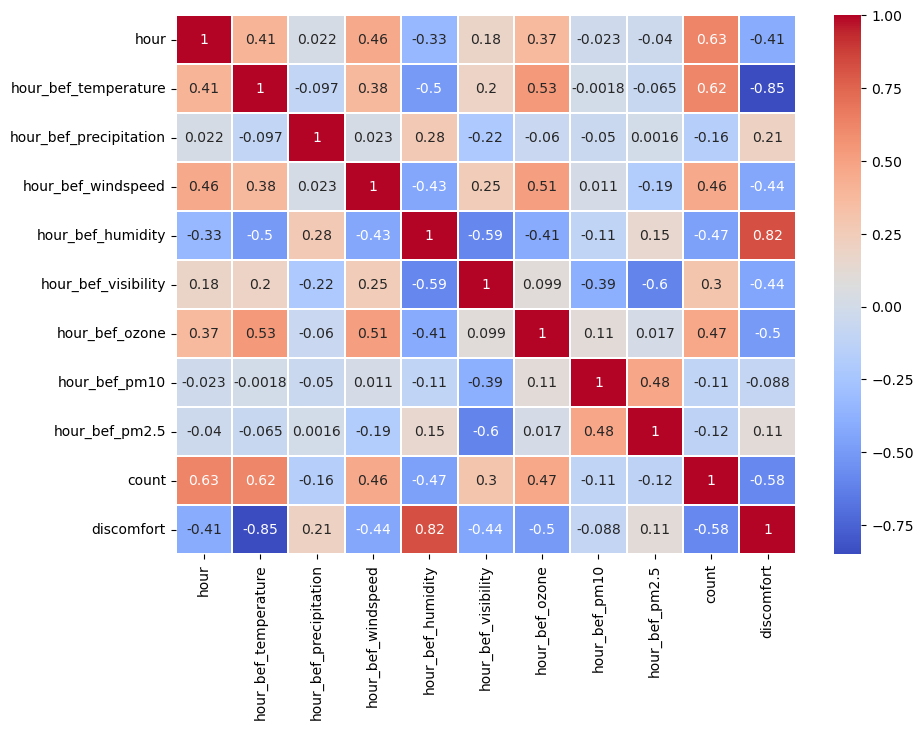

In [17]:
fig, ax = plt.subplots(figsize=(10,7))

sns.heatmap(train_df.corr(), annot=True, linewidths=0.1, cmap="coolwarm")

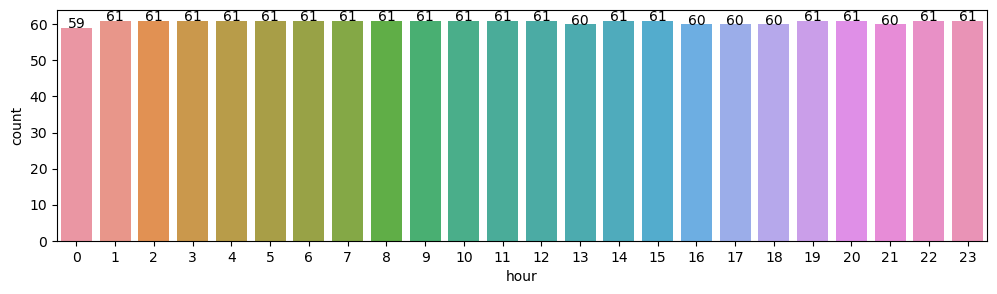

In [18]:
# hour 개수 분포

fig, ax = plt.subplots(1, 1, figsize=(12, 3))

sns.countplot(x='hour', data=train_df, ax=ax)

# 정확한 값 표시
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2. , height,
                  int(height), ha = 'center', size = 10)

plt.show()

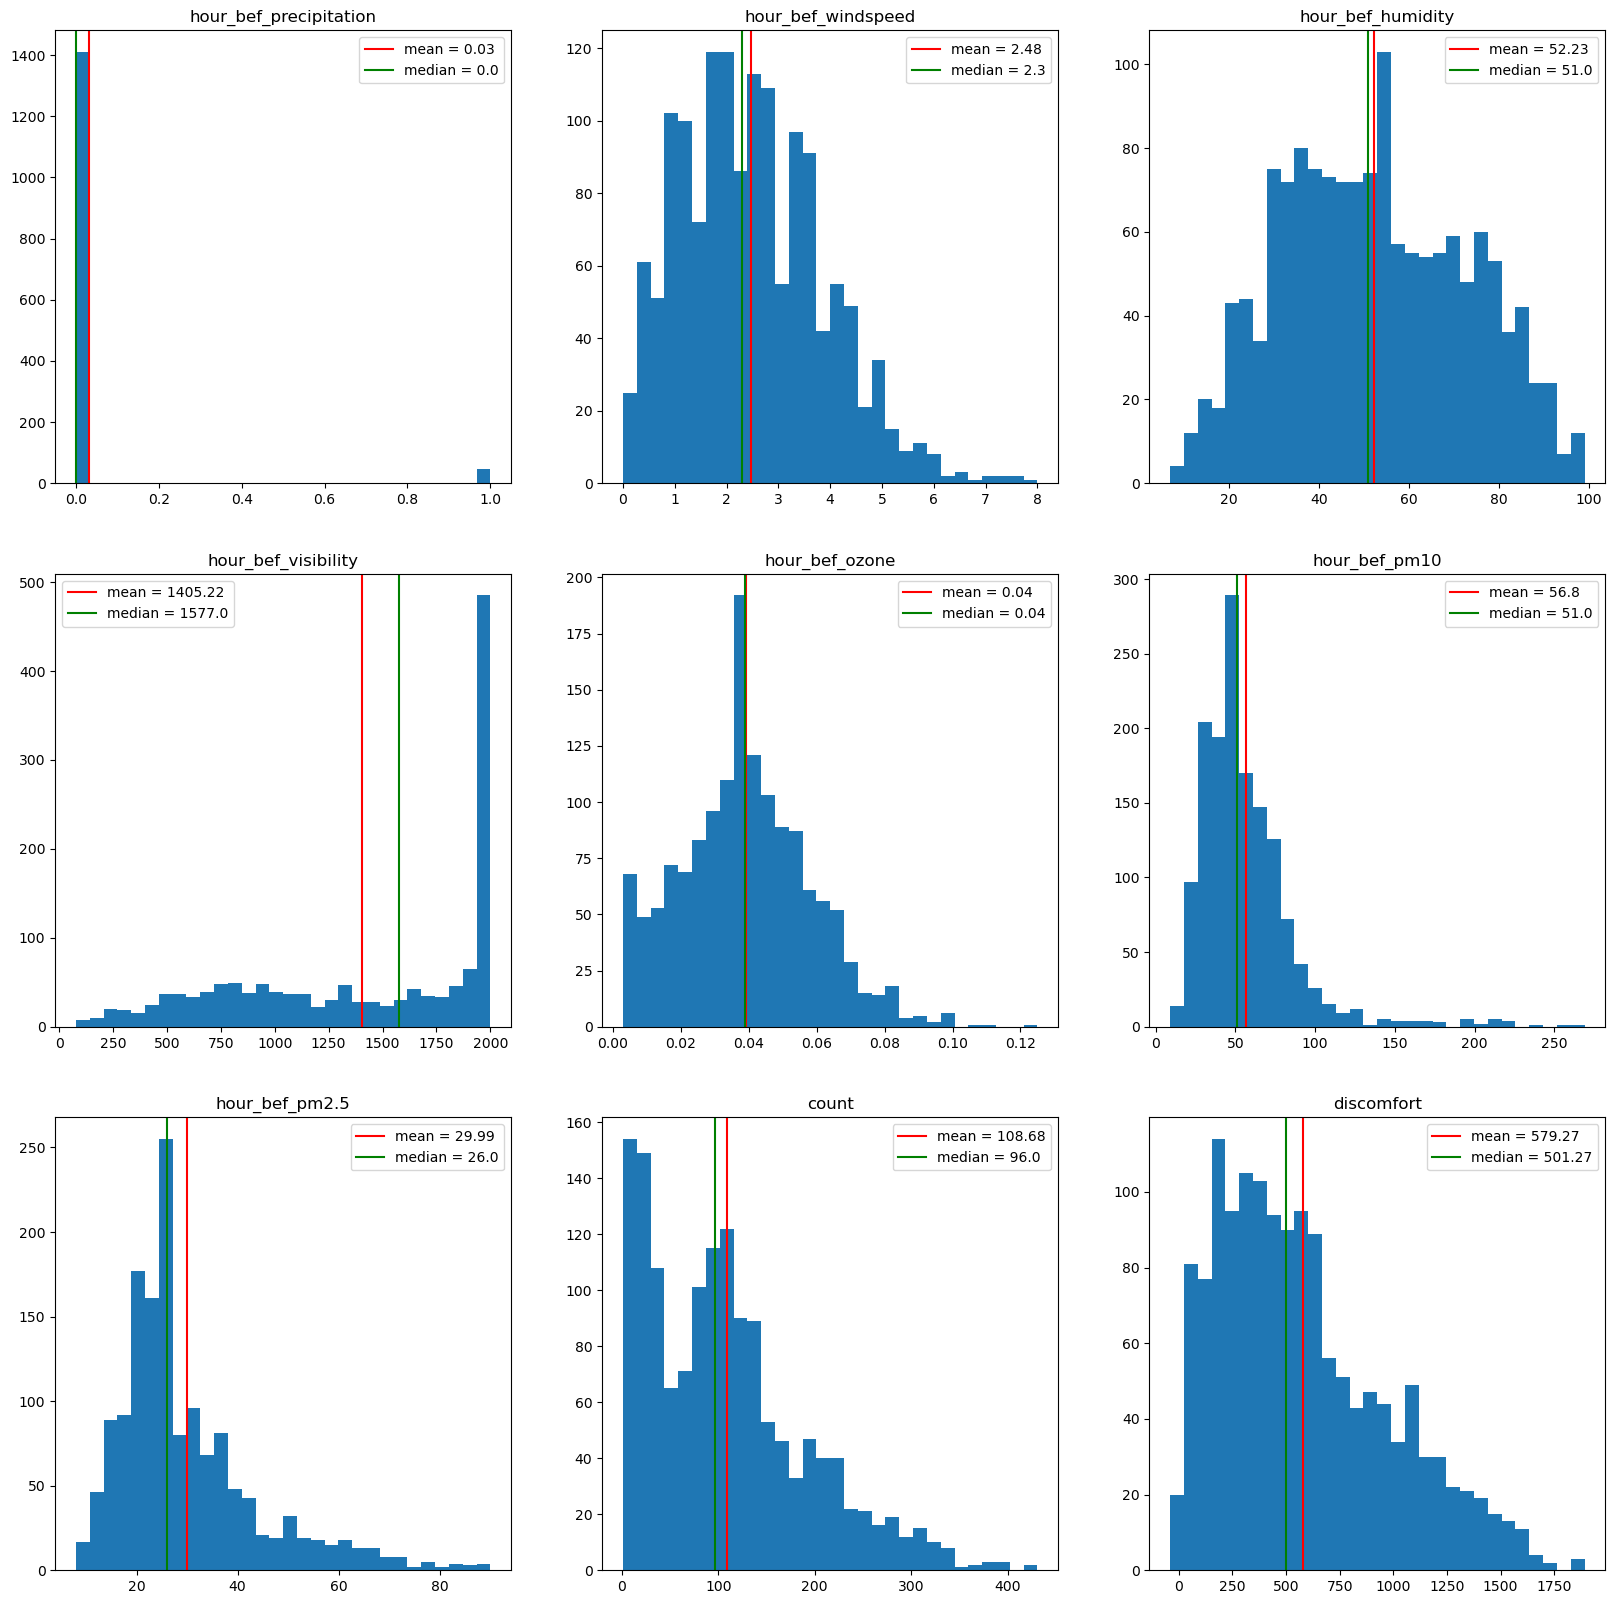

In [19]:
# 각 column의 분포 확인

fig, axes =plt.subplots(3, 3, figsize = (20, 20))
axes = axes.flatten()

for i, col_name in enumerate(train_df.columns[2:]):
    axes[i].hist(train_df[col_name], bins=30)
    axes[i].set_title(col_name)
    axes[i].axvline(train_df.describe()[col_name]['mean'], c='r', label = f"mean = {round(train_df.describe()[col_name]['mean'], 2)}")
    axes[i].axvline(train_df.describe()[col_name]['50%'], c='g', label = f"median = {round(train_df.describe()[col_name]['50%'], 2)}")
    axes[i].legend()

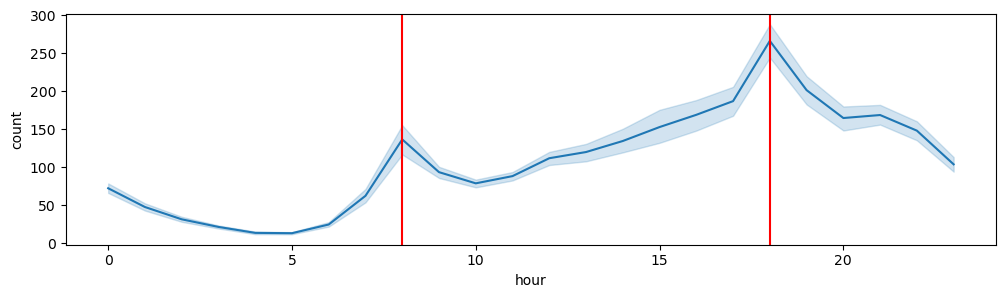

In [20]:
# 시간대별 따릉이 대여 수

fig, ax = plt.subplots(1, 1, figsize=(12, 3))

sns.lineplot(x="hour", y="count", data=train_df, ax=ax)
ax.axvline(8, color='red')
ax.axvline(18, color='red')

plt.show()

출퇴근 시간에 수요가 많다.

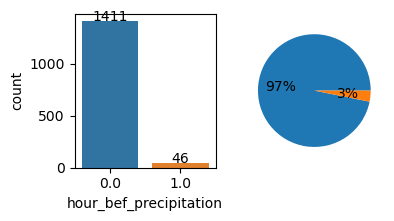

In [21]:
# 비가 온 날과 안 온 날 분포

fig, axes = plt.subplots(1, 2, figsize=(4, 2))

sns.countplot(x='hour_bef_precipitation', data=train_df, ax=axes[0], palette='tab10')
# 정확한 값 표시
for p in axes[0].patches:
    height = p.get_height()
    axes[0].text(p.get_x() + p.get_width() / 2. , height,
                  int(height), ha = 'center', size = 10)

axes[1].pie(train_df['hour_bef_precipitation'].value_counts(),#colors=color, ###
         autopct='%1.0f%%')

plt.show()

hour_bef_precipitation
0.0    156805.0
1.0      1549.0
Name: count, dtype: float64


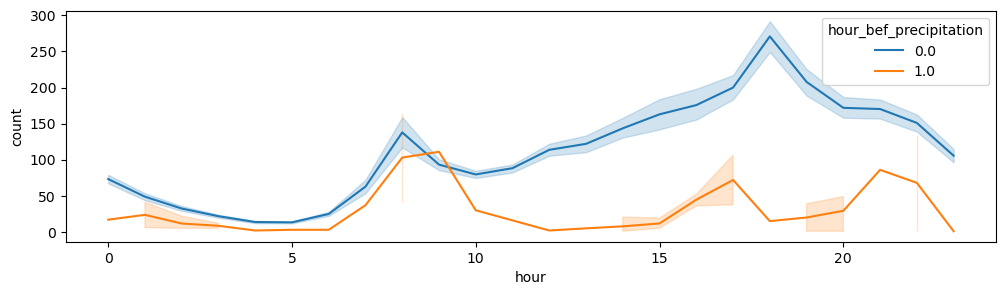

In [22]:
# 비 온 날과 안 온 날 따릉이 대여 수
fig, ax = plt.subplots(1, 1, figsize=(12, 3))

print(train_df.groupby("hour_bef_precipitation")["count"].sum())
sns.lineplot(x="hour", y="count", hue='hour_bef_precipitation', data=train_df, ax=ax)

plt.show()

비가 온 날의 데이터 개수가 매우 작긴 하지만, 비가 온 날 10시 이후 자전거 수요가 매우 적다.

미세먼지 기준

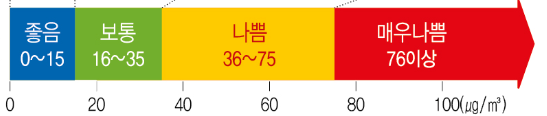

In [23]:
# 미세먼지 수치 -> 매우 나쁨(very bad), 나쁨(bad), 보통(not bad), 좋음(good)

pm = ['hour_bef_pm10','hour_bef_pm2.5']

#정렬 순서
pm_order=['good', 'not bad', 'bad', 'very bad']
pm_int2tag = lambda x : 'very bad' if x >=76 else 'bad' if x>=36 else 'not bad' if x>=16 else 'good'

for pm_i in pm:
  train_df[pm_i+"_tag"] = train_df[pm_i].apply(pm_int2tag)

In [24]:
train_df.head()

,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count,discomfort,hour_bef_pm10_tag,hour_bef_pm2.5_tag
0,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0,900.404,very bad,not bad
1,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0,336.707,bad,bad
2,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0,985.382,not bad,not bad
3,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0,979.793,bad,bad
4,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0,58.310,not bad,good


In [25]:
# 미세먼지 수준별 개수와 count 합계
pm10_df = train_df.groupby("hour_bef_pm10_tag").agg({"hour_bef_pm10": "count", "count": "sum"})
pm2_5_df = train_df.groupby("hour_bef_pm2.5_tag").agg({"hour_bef_pm2.5": "count", "count": "sum"})

# 좋음->아주나쁨 순으로 index 정렬
pm10_df = pm10_df.reindex(pm_order)
pm2_5_df = pm2_5_df.reindex(pm_order)

In [26]:
pm2_5_df

,hour_bef_pm2.5,count
hour_bef_pm2.5_tag,,
good,116,16762.0
not bad,965,103210.0
bad,358,36955.0
very bad,18,1427.0


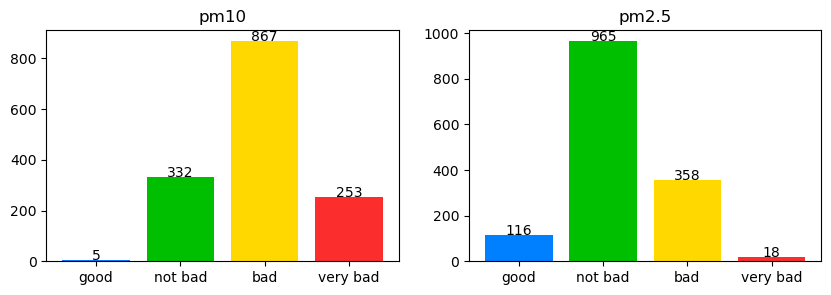

In [27]:
# 미세먼지 수준의 분포
color_list = ["#007fff","#00bf00","#ffd800","#fc2d2d"]

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

axes[0].bar(x=pm10_df.index, height="hour_bef_pm10", data=pm10_df, color=color_list)
axes[1].bar(x=pm2_5_df.index, height="hour_bef_pm2.5", data=pm2_5_df, color=color_list)

# 정확한 값 표시
for i in range(len(axes)):
    for p in axes[i].patches:
        height = p.get_height()
        axes[i].text(p.get_x() + p.get_width() / 2. , height,
                    int(height), ha = 'center', size = 10)

axes[0].set_title("pm10")
axes[1].set_title("pm2.5")

plt.show()

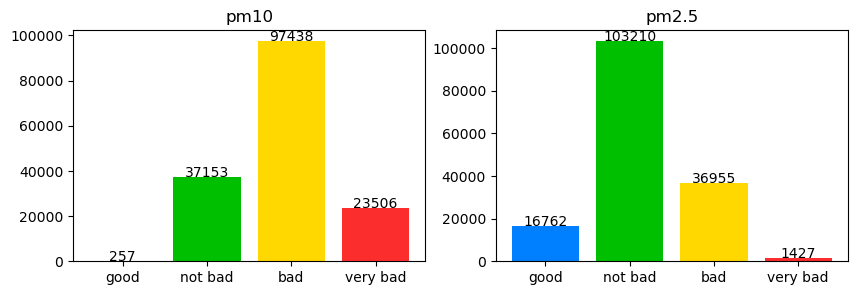

In [28]:
# 미세먼지 수준에 따른 따릉이 대여 수
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

axes[0].bar(x=pm10_df.index, height="count", data=pm10_df, color=color_list)
axes[1].bar(x=pm2_5_df.index, height="count", data=pm2_5_df, color=color_list)

# 정확한 값 표시
for i in range(len(axes)):
    for p in axes[i].patches:
        height = p.get_height()
        axes[i].text(p.get_x() + p.get_width() / 2. , height,
                    int(height), ha = 'center', size = 10)

axes[0].set_title("pm10")
axes[1].set_title("pm2.5")

plt.show()

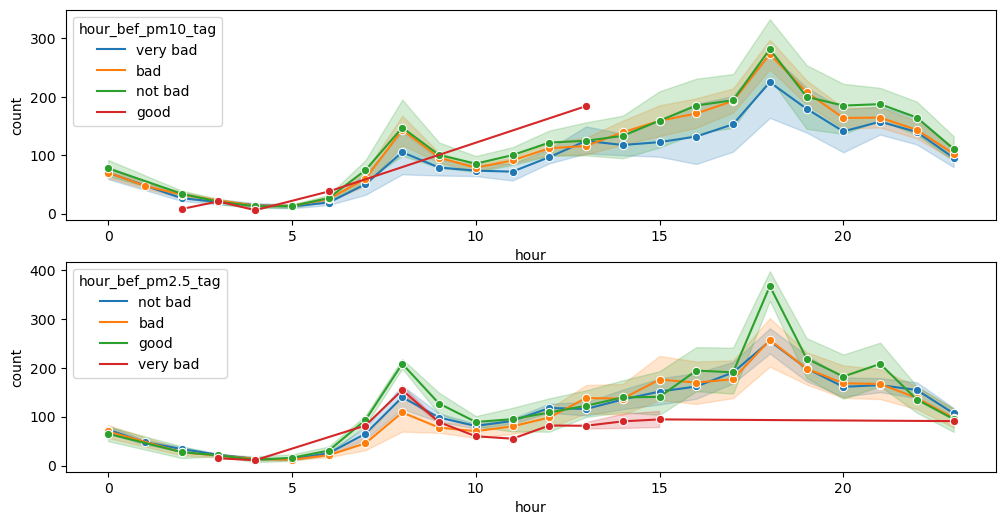

In [29]:
# 시간과 미세먼지에 따른 따릉이 대여 수

fig, axes = plt.subplots(2, 1, figsize=(12, 6))

sns.lineplot(x="hour", y="count", hue='hour_bef_pm10_tag', data=train_df, ax=axes[0], marker='o')
sns.lineplot(x="hour", y="count", hue='hour_bef_pm2.5_tag', data=train_df, ax=axes[1], marker='o')

plt.show()

초미세먼지(pm2.5)가 매우 나쁜 날의 퇴근 시간 수요가 매우 적다.

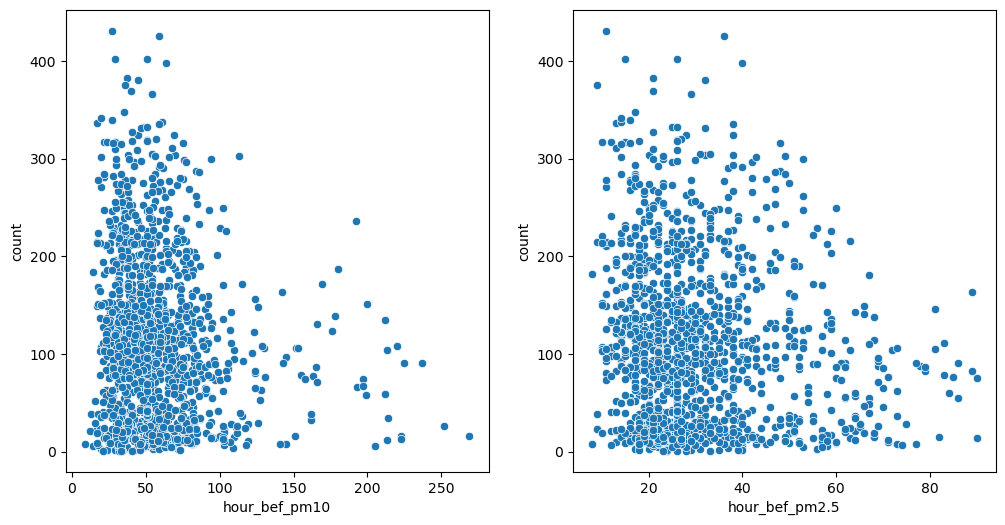

In [30]:
# 미세먼지와 초미세먼지에 따른 따릉이 대여 수

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.scatterplot(x="hour_bef_pm10", y="count", data=train_df, ax=axes[0])
sns.scatterplot(x="hour_bef_pm2.5", y="count", data=train_df, ax=axes[1], marker='o')

plt.show()


In [31]:
# tag를 labelencoding 해주기

le = LabelEncoder()
train_df['hour_bef_pm10_tag'] = le.fit_transform(train_df['hour_bef_pm10_tag'])
train_df['hour_bef_pm2.5_tag'] = le.fit_transform(train_df['hour_bef_pm2.5_tag'])


In [32]:
train_df.head()

,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count,discomfort,hour_bef_pm10_tag,hour_bef_pm2.5_tag
0,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0,900.404,3,2
1,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0,336.707,0,0
2,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0,985.382,2,2
3,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0,979.793,0,0
4,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0,58.310,2,1


In [33]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1457 entries, 0 to 1458
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   hour                    1457 non-null   int64  
 1   hour_bef_temperature    1457 non-null   float64
 2   hour_bef_precipitation  1457 non-null   float64
 3   hour_bef_windspeed      1457 non-null   float64
 4   hour_bef_humidity       1457 non-null   float64
 5   hour_bef_visibility     1457 non-null   float64
 6   hour_bef_ozone          1457 non-null   float64
 7   hour_bef_pm10           1457 non-null   float64
 8   hour_bef_pm2.5          1457 non-null   float64
 9   count                   1457 non-null   float64
 10  discomfort              1457 non-null   float64
 11  hour_bef_pm10_tag       1457 non-null   int32  
 12  hour_bef_pm2.5_tag      1457 non-null   int32  
dtypes: float64(10), int32(2), int64(1)
memory usage: 148.0 KB


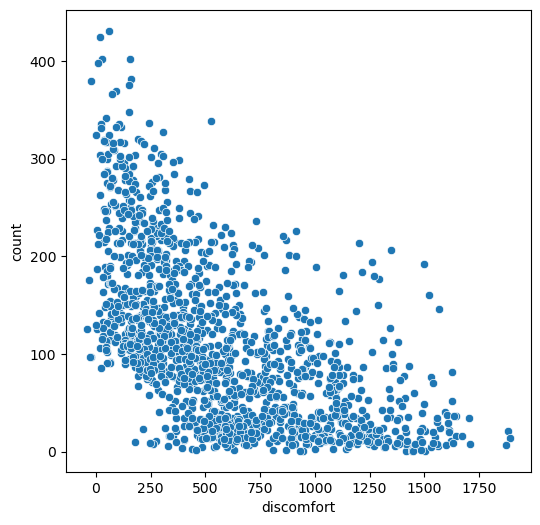

In [34]:
# 불쾌지수에 따른 따릉이 대여 수

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

sns.scatterplot(x="discomfort", y="count", data=train_df, ax=ax)

plt.show()

### Data 준비

In [35]:
# 미세먼지 tag 열은 사용하지 않음
x_features = train_df.drop(['count', 'hour_bef_pm10_tag', 'hour_bef_pm2.5_tag'], axis=1)
y_target = train_df['count']


In [36]:
# stratified by 비 오는 날
x_train, x_val, y_train, y_val = train_test_split(x_features,
                                                  y_target,
                                                  test_size=0.2,
                                                  random_state=random_seed,
                                                  stratify=train_df["hour_bef_precipitation"])

In [37]:
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

(1165, 10) (292, 10) (1165,) (292,)


## Model & Result

### 평가 metric

In [38]:
# log 값 변환 시 NaN등의 이슈로 log() 가 아닌 log1p() 를 이용하여 RMSLE 계산
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# 사이킷런의 mean_square_error() 를 이용하여 RMSE 계산
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

# MSE, RMSE, RMSLE 를 모두 계산
def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    # MAE 는 scikit learn의 mean_absolute_error() 로 계산
    mae_val = mean_absolute_error(y,pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))


In [39]:
# 모델별 성능 확인을 위한 함수

my_predictions = {}

colors = ['r', 'c', 'm', 'y', 'k', 'khaki', 'teal', 'orchid', 'sandybrown',
          'greenyellow', 'dodgerblue', 'deepskyblue', 'rosybrown', 'firebrick',
          'deeppink', 'crimson', 'salmon', 'darkred', 'olivedrab', 'olive',
          'forestgreen', 'royalblue', 'indigo', 'navy', 'mediumpurple', 'chocolate',
          'gold', 'darkorange', 'seagreen', 'turquoise', 'steelblue', 'slategray',
          'peru', 'midnightblue', 'slateblue', 'dimgray', 'cadetblue', 'tomato'
         ]


def plot_predictions(name_, pred, actual):
    df = pd.DataFrame({'prediction': pred, 'actual': actual})
    df = df.sort_values(by='actual').reset_index(drop=True)

    plt.figure(figsize=(12, 9))
    plt.scatter(df.index, df['prediction'], marker='x', color='r')
    plt.scatter(df.index, df['actual'], alpha=0.7, marker='o', color='black')
    plt.title(name_, fontsize=15)
    plt.legend(['prediction', 'actual'], fontsize=12)
    plt.show()

def rmse_eval(name_, pred, actual):
    global predictions
    global colors

    # plot_predictions(name_, pred, actual)

    rmse_val = rmse(actual, pred)
    my_predictions[name_] = rmse_val

    y_value = sorted(my_predictions.items(), key=lambda x: x[1], reverse=True)

    df = pd.DataFrame(y_value, columns=['model', 'rmse'])
    print(df)
    min_ = df['rmse'].min() - 10
    max_ = df['rmse'].max() + 10

    length = len(df)

    plt.figure(figsize=(10, length))
    ax = plt.subplot()
    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df['model'], fontsize=15)
    bars = ax.barh(np.arange(len(df)), df['rmse'])

    for i, v in enumerate(df['rmse']):
        idx = np.random.choice(len(colors))
        bars[i].set_color(colors[idx])
        ax.text(v + 2, i, str(round(v, 3)), color='k', fontsize=15, fontweight='bold')

    plt.title('RMSE Error', fontsize=18)
    plt.xlim(min_, max_)

    plt.show()

def remove_model(name_):
    global my_predictions
    try:
        del my_predictions[name_]
    except KeyError:
        return False
    return True

### baseline

RMSLE: 0.817, RMSE: 48.104, MAE: 36.977
                         model       rmse
0  LinearRegression (baseline)  48.103872


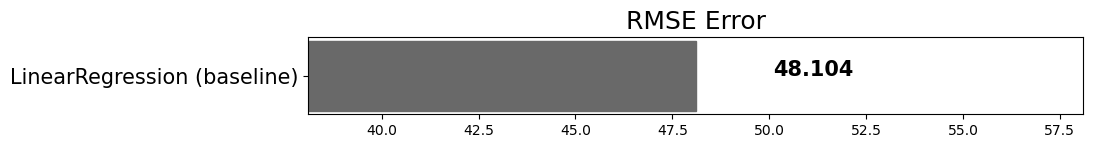

In [40]:
# 베이스라인 LinearRegression

lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train)
y_pred = lr_reg.predict(x_val)

evaluate_regr(y_val , y_pred)
rmse_eval('LinearRegression (baseline)', y_pred, y_val)

In [41]:
# 실제 값과 예측값이 어느 정도 차이나는지
def get_top_error_data(y_test, pred, n_tops = 5):
    # DataFrame에 컬럼들로 실제 대여횟수(count)와 예측 값을 서로 비교 할 수 있도록 생성.
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count']= np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    # 예측값과 실제값이 가장 큰 데이터 순으로 출력.
    print(result_df.sort_values('diff', ascending=False)[:n_tops])

get_top_error_data(y_val, y_pred, n_tops=5)

     real_count  predicted_count   diff
38        398.0            216.0  182.0
213        24.0            164.0  140.0
141       318.0            182.0  136.0
221       320.0            184.0  136.0
58        273.0            143.0  130.0


회귀에서 큰 예측 오류가 발생할 경우, target 값(count 컬럼)의 분포가 왜곡된 형태를 이루고 있는지 살펴봐야합니다.

Target 값의 분포는 정규 분포 형태가 가장 좋습니다.

왜곡된 값을 정규 분포 형태로 바꾸는 가장 일반적인 방법은 로그를 적용해 변환하는 것입니다.

<Axes: >

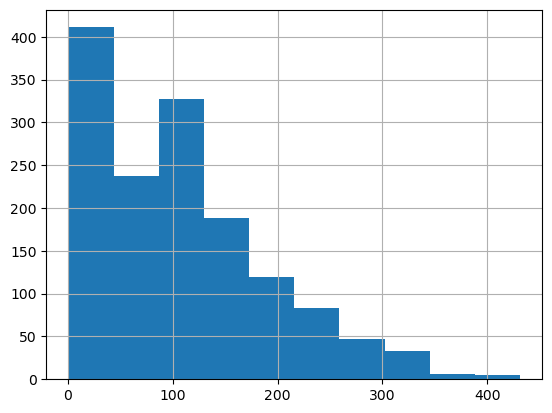

In [42]:
# count 값의 분포
train_df['count'].hist()

<Axes: >

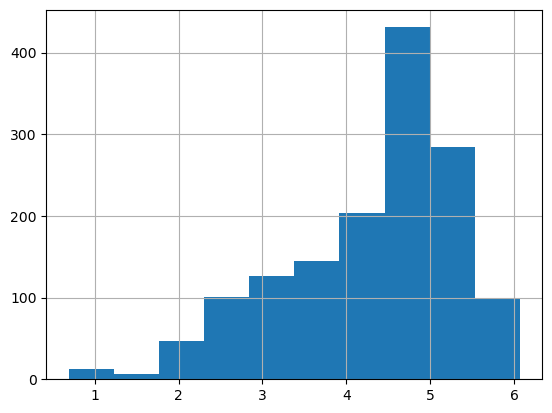

In [43]:
# log를 취한 count 값의 분포
y_log_transform = np.log1p(train_df['count'])
y_log_transform.hist()

RMSLE: 0.622, RMSE: 48.495, MAE: 34.624
                           model       rmse
0  LinearRegression (log target)  48.495188
1    LinearRegression (baseline)  48.103872


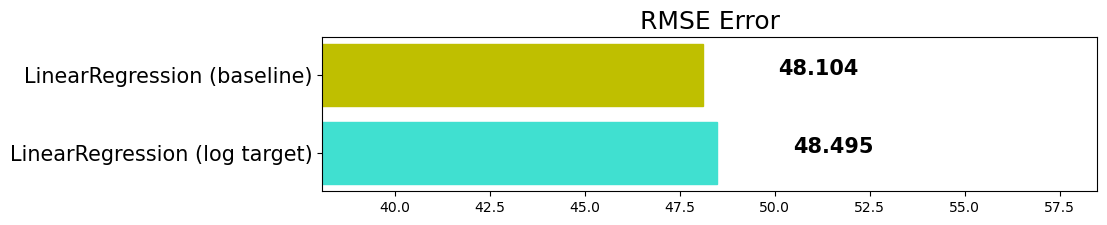

In [44]:
# 타깃 칼럼인 count 값을 log1p로 로그 변환
y_target_log = np.log1p(train_df['count'])

# 로그 변환된 y_target_log를 반영하여 학습/테스트 데이터 셋 분할
x_train, x_val, y_train, y_val = train_test_split(x_features,
                                                    y_target_log,
                                                    test_size=0.2,
                                                    random_state=random_seed,
                                                    stratify=train_df["hour_bef_precipitation"])
lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train)
pred = lr_reg.predict(x_val)

# 테스트 데이터 셋의 Target 값은 Log 변환되었으므로 다시 expm1를 이용하여 원래 scale로 변환
y_test_exp = np.expm1(y_val)

# 예측 값 역시 Log 변환된 타깃 기반으로 학습되어 예측되었으므로 다시 exmpl으로 scale변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp ,pred_exp)
rmse_eval('LinearRegression (log target)', pred_exp, y_test_exp)

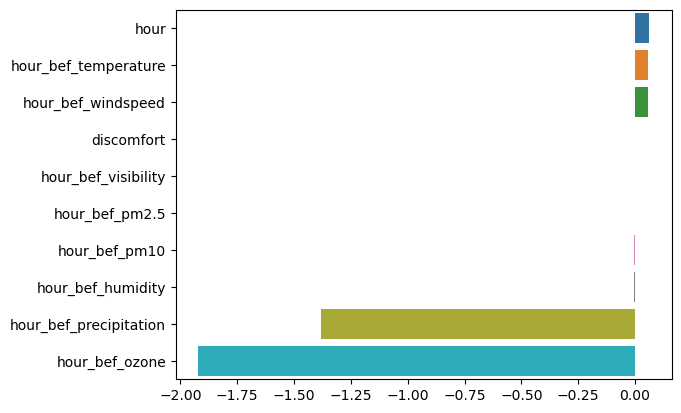

In [45]:
coef = pd.Series(lr_reg.coef_, index=x_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)
plt.savefig('log_transform.tif', format='tif', dpi=300, bbox_inches='tight')

In [46]:
# 모델과 학습/테스트 데이터 셋을 입력하면 성능 평가 수치를 반환
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###',model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)
    rmse_eval(model.__class__.__name__, pred, y_test)

릿지, 라쏘, 엘라스틱넷

### Ridge ###
RMSLE: 0.622, RMSE: 48.026, MAE: 34.478
                           model       rmse
0  LinearRegression (log target)  48.495188
1    LinearRegression (baseline)  48.103872
2                          Ridge  48.026434


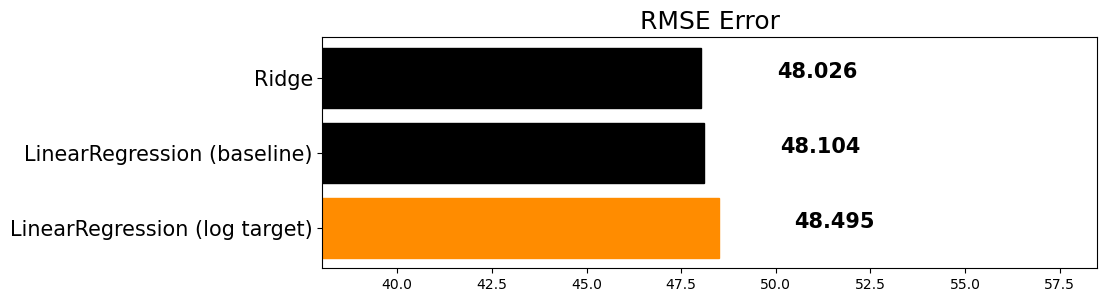

### Lasso ###
RMSLE: 0.622, RMSE: 48.160, MAE: 34.524
                           model       rmse
0  LinearRegression (log target)  48.495188
1                          Lasso  48.159539
2    LinearRegression (baseline)  48.103872
3                          Ridge  48.026434


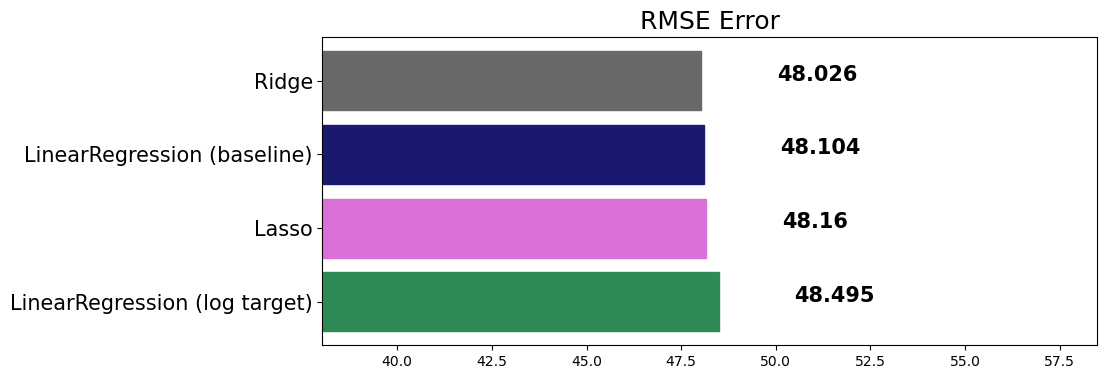

### ElasticNet ###
RMSLE: 0.653, RMSE: 51.142, MAE: 36.792
                           model       rmse
0                     ElasticNet  51.141762
1  LinearRegression (log target)  48.495188
2                          Lasso  48.159539
3    LinearRegression (baseline)  48.103872
4                          Ridge  48.026434


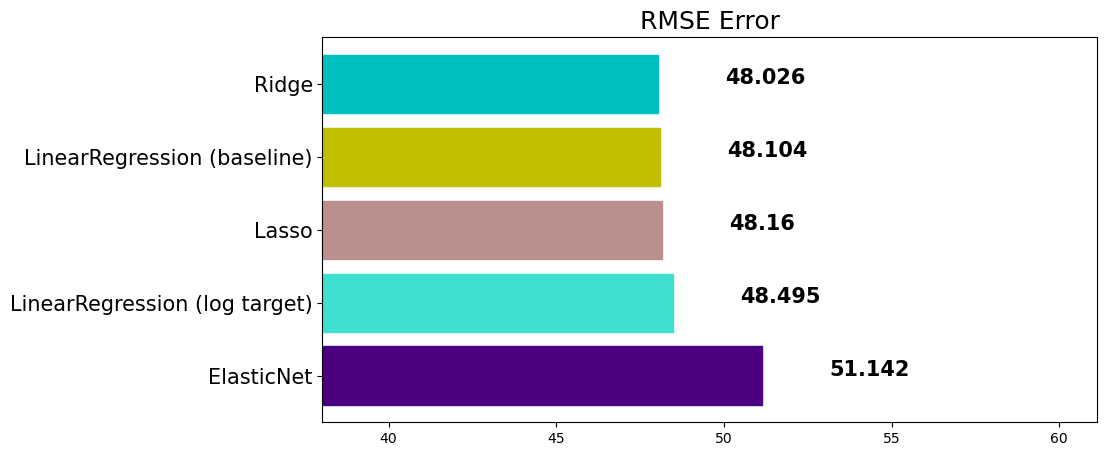

In [47]:
ridge = Ridge(alpha=1, random_state=random_seed)
lasso = Lasso(alpha=0.01, random_state=random_seed)
elasticnet = ElasticNet(alpha=0.5, l1_ratio=1, random_state=random_seed)


for model in [ridge, lasso, elasticnet]:
    # XGBoost의 경우 DataFrame이 입력 될 경우 버전에 따라 오류 발생 가능. ndarray로 변환.
    get_model_predict(model, x_train.values, x_val.values, y_train.values, y_val.values,is_expm1=True)

랜덤 포레스트, GBM, XGBoost, LightGBM model

### RandomForestRegressor ###
RMSLE: 0.490, RMSE: 39.497, MAE: 26.000
                           model       rmse
0                     ElasticNet  51.141762
1  LinearRegression (log target)  48.495188
2                          Lasso  48.159539
3    LinearRegression (baseline)  48.103872
4                          Ridge  48.026434
5          RandomForestRegressor  39.497197


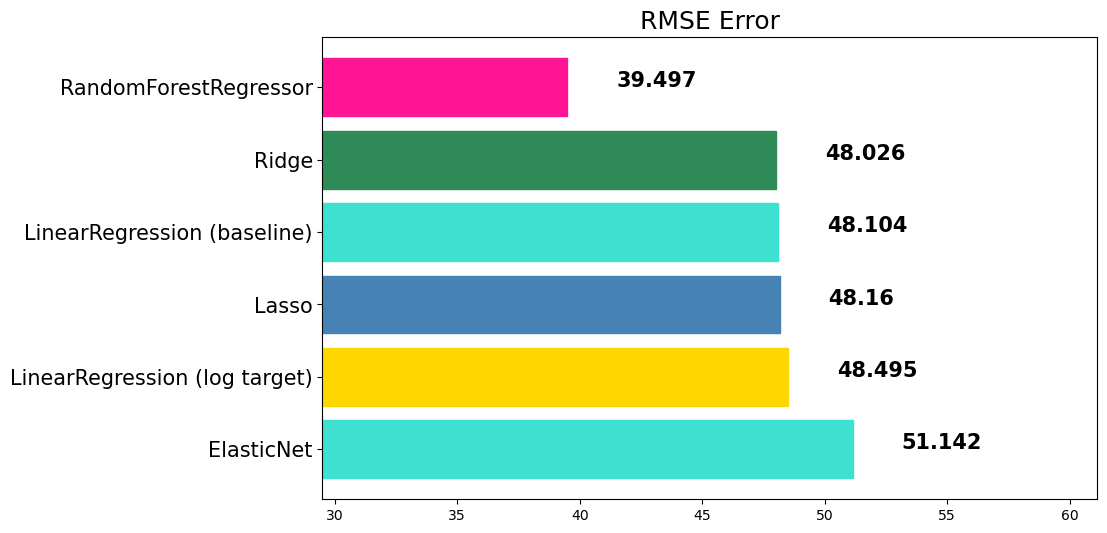

### GradientBoostingRegressor ###
RMSLE: 0.504, RMSE: 38.334, MAE: 25.519
                           model       rmse
0                     ElasticNet  51.141762
1  LinearRegression (log target)  48.495188
2                          Lasso  48.159539
3    LinearRegression (baseline)  48.103872
4                          Ridge  48.026434
5          RandomForestRegressor  39.497197
6      GradientBoostingRegressor  38.333924


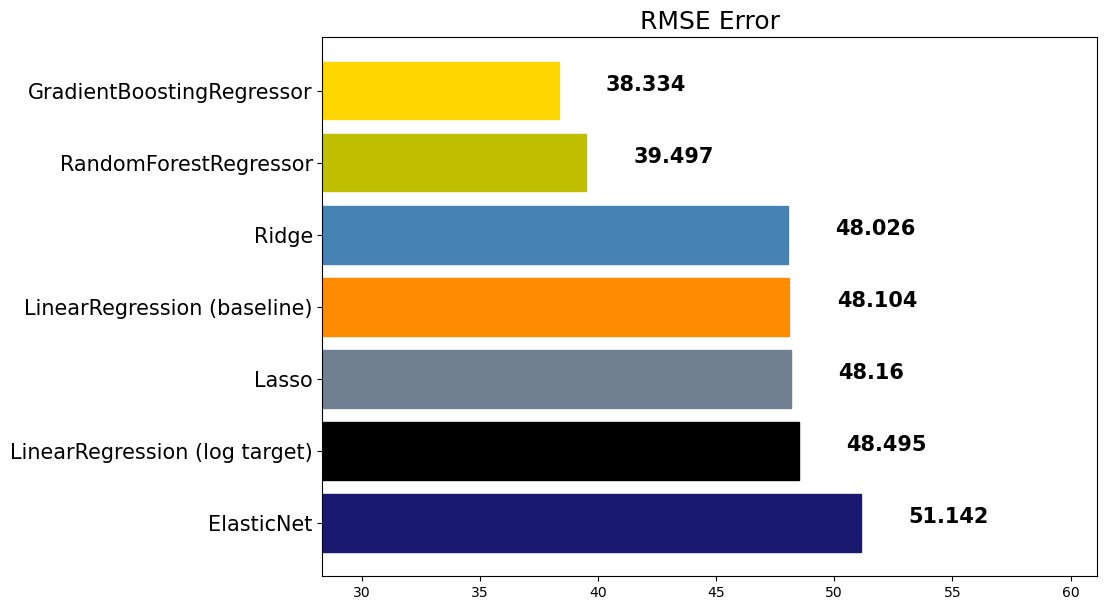

### XGBRegressor ###
RMSLE: 0.510, RMSE: 40.663, MAE: 25.690
                           model       rmse
0                     ElasticNet  51.141762
1  LinearRegression (log target)  48.495188
2                          Lasso  48.159539
3    LinearRegression (baseline)  48.103872
4                          Ridge  48.026434
5                   XGBRegressor  40.662665
6          RandomForestRegressor  39.497197
7      GradientBoostingRegressor  38.333924


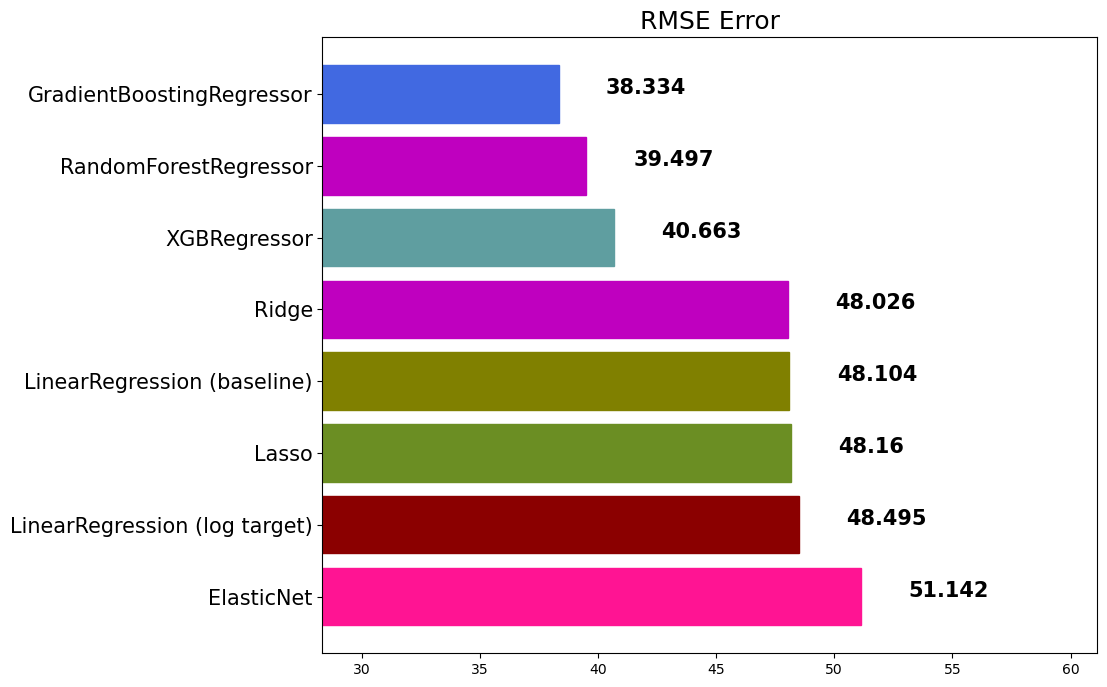

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1118
[LightGBM] [Info] Number of data points in the train set: 1165, number of used features: 10
[LightGBM] [Info] Start training from score 4.323580
### LGBMRegressor ###
RMSLE: 0.469, RMSE: 42.957, MAE: 28.548
                           model       rmse
0                     ElasticNet  51.141762
1  LinearRegression (log target)  48.495188
2                          Lasso  48.159539
3    LinearRegression (baseline)  48.103872
4                          Ridge  48.026434
5                  LGBMRegressor  42.956500
6                   XGBRegressor  40.662665
7          RandomForestRegressor  39.497197
8      GradientBoostingRegressor  38.333924


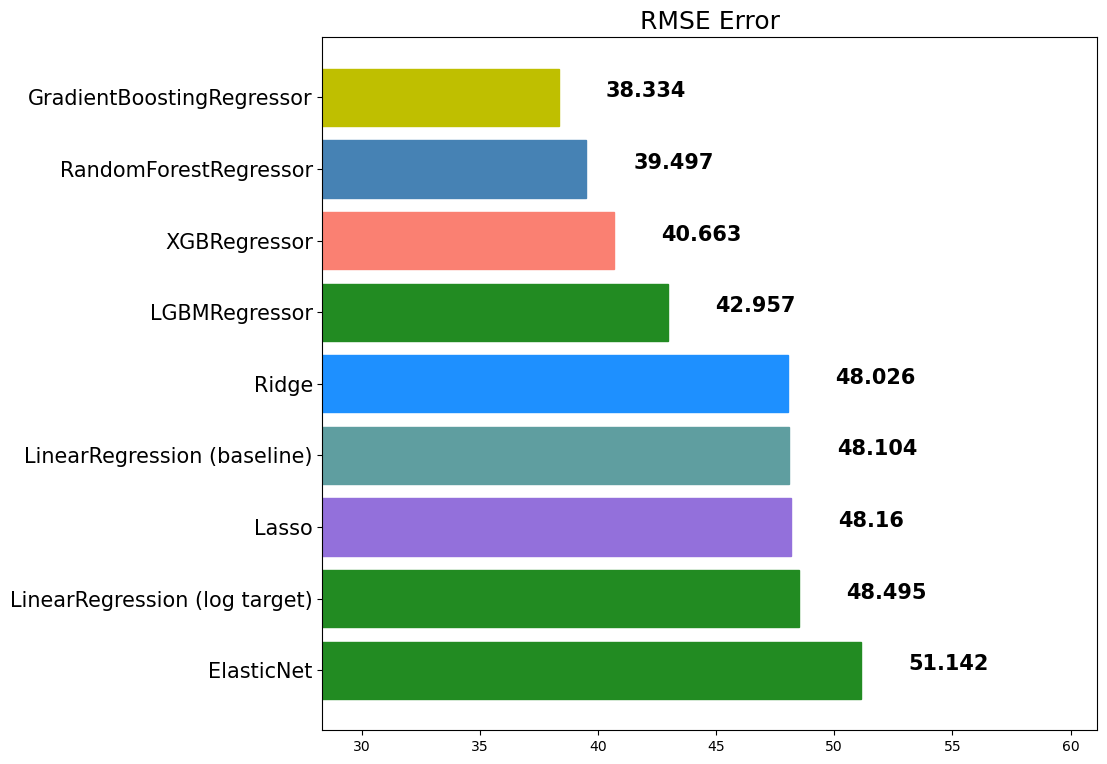

In [48]:
# 랜덤 포레스트, GBM, XGBoost, LightGBM model 별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators=500, random_state=random_seed)
gbm_reg = GradientBoostingRegressor(n_estimators=500, random_state=random_seed)
xgb_reg = XGBRegressor(n_estimators=500, random_state=random_seed)
lgbm_reg = LGBMRegressor(n_estimators=500, random_state=random_seed)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    # XGBoost의 경우 DataFrame이 입력 될 경우 버전에 따라 오류 발생 가능. ndarray로 변환.
    get_model_predict(model, x_train.values, x_val.values, y_train.values, y_val.values,is_expm1=True)


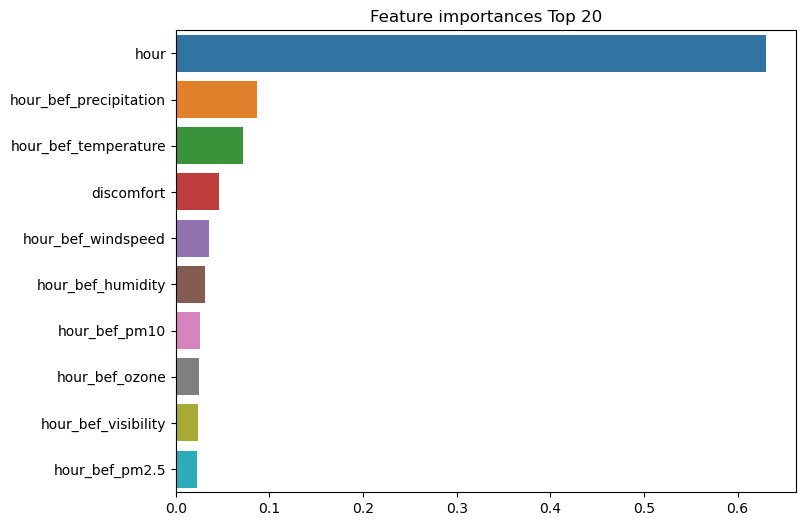

<Figure size 640x480 with 0 Axes>

In [49]:
# 랜덤포레스트의 feature importances
ftr_importances_values = rf_reg.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=x_train.columns  )
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('rf_feature_importances_top20.tif', format='tif', dpi=300, bbox_inches='tight')

### hyperparameter tuning

In [50]:
# XGBoost tuning

xgb = XGBRegressor(random_state=random_seed)
params = {'learning_rate':[0.01, 0.05, 0.1, 0.5],
            'n_estimators': [100, 200, 500],
            'max_depth': [2, 3, 4, 5]}
xgb_grid = GridSearchCV(xgb, param_grid=params, cv = 5, n_jobs=-1,  scoring='neg_root_mean_squared_error')
xgb_grid.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.5],
                         'max_depth': [2, 3, 4, 5],
                         'n_estimators': [100, 200, 500]},
             scoring='neg_root_mean_squared_error')

In [51]:
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

-0.45814959807167044
{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 500}


In [52]:
from xgboost.callback import EarlyStopping

[0]	validation_0-rmse:0.98643
[1]	validation_0-rmse:0.95257
[2]	validation_0-rmse:0.92077
[3]	validation_0-rmse:0.89142
[4]	validation_0-rmse:0.86364
[5]	validation_0-rmse:0.83710
[6]	validation_0-rmse:0.81223
[7]	validation_0-rmse:0.79002
[8]	validation_0-rmse:0.76868
[9]	validation_0-rmse:0.74928
[10]	validation_0-rmse:0.73081
[11]	validation_0-rmse:0.71320
[12]	validation_0-rmse:0.69740
[13]	validation_0-rmse:0.68339
[14]	validation_0-rmse:0.66871
[15]	validation_0-rmse:0.65629
[16]	validation_0-rmse:0.64495
[17]	validation_0-rmse:0.63456
[18]	validation_0-rmse:0.62556
[19]	validation_0-rmse:0.61614
[20]	validation_0-rmse:0.60774
[21]	validation_0-rmse:0.60018
[22]	validation_0-rmse:0.59282
[23]	validation_0-rmse:0.58579
[24]	validation_0-rmse:0.57884
[25]	validation_0-rmse:0.57215
[26]	validation_0-rmse:0.56590
[27]	validation_0-rmse:0.56121
[28]	validation_0-rmse:0.55571
[29]	validation_0-rmse:0.55174
[30]	validation_0-rmse:0.54729
[31]	validation_0-rmse:0.54212
[32]	validation_0-

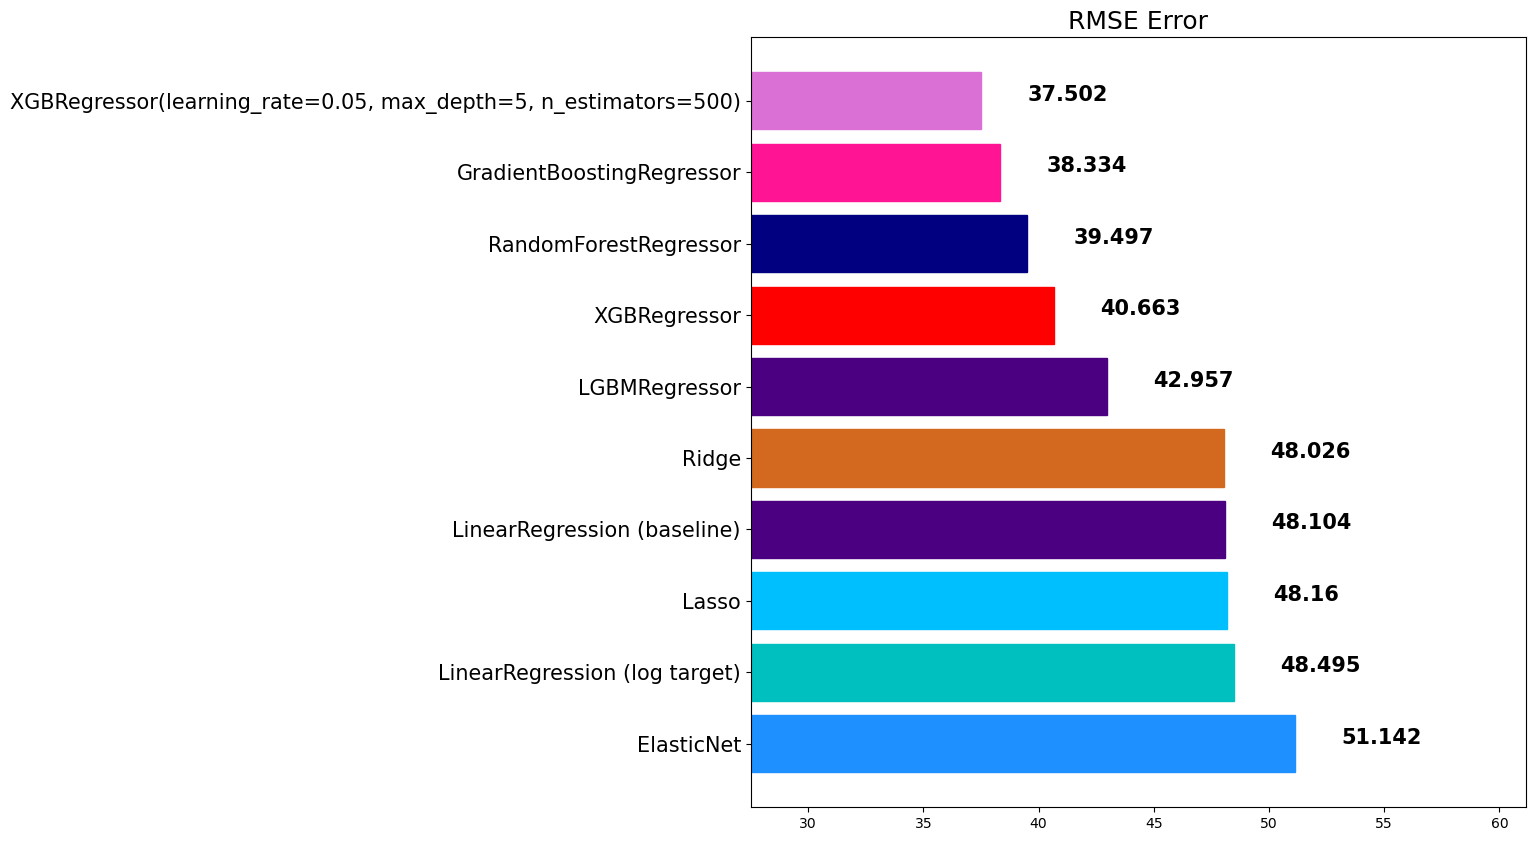

In [53]:
xgb_best = XGBRegressor(learning_rate=0.05, max_depth=5, n_estimators=500)

early_stop = EarlyStopping(rounds=20,metric_name='rmse',data_name="validation_0", save_best=True)
xgb_best.fit(x_train, y_train, eval_set=[(x_val, y_val)], eval_metric='rmse', callbacks=[early_stop])
xgb_best_pred = xgb_best.predict(x_val)

# log 취해진 y를 원상복구
y_test = np.expm1(y_val)
pred = np.expm1(xgb_best_pred)

evaluate_regr(y_test, pred)
rmse_eval('XGBRegressor(learning_rate=0.05, max_depth=5, n_estimators=500)', pred, y_test)

### scaler 파이프라인

RMSLE: 0.495, RMSE: 37.536, MAE: 24.133
                                                model       rmse
0                                          ElasticNet  51.141762
1                       LinearRegression (log target)  48.495188
2                                               Lasso  48.159539
3                         LinearRegression (baseline)  48.103872
4                                               Ridge  48.026434
5                                       LGBMRegressor  42.956500
6                                        XGBRegressor  40.662665
7                               RandomForestRegressor  39.497197
8                           GradientBoostingRegressor  38.333924
9   StandardScaler + XGBRegressor(learning_rate=0....  37.536126
10  XGBRegressor(learning_rate=0.05, max_depth=5, ...  37.502008


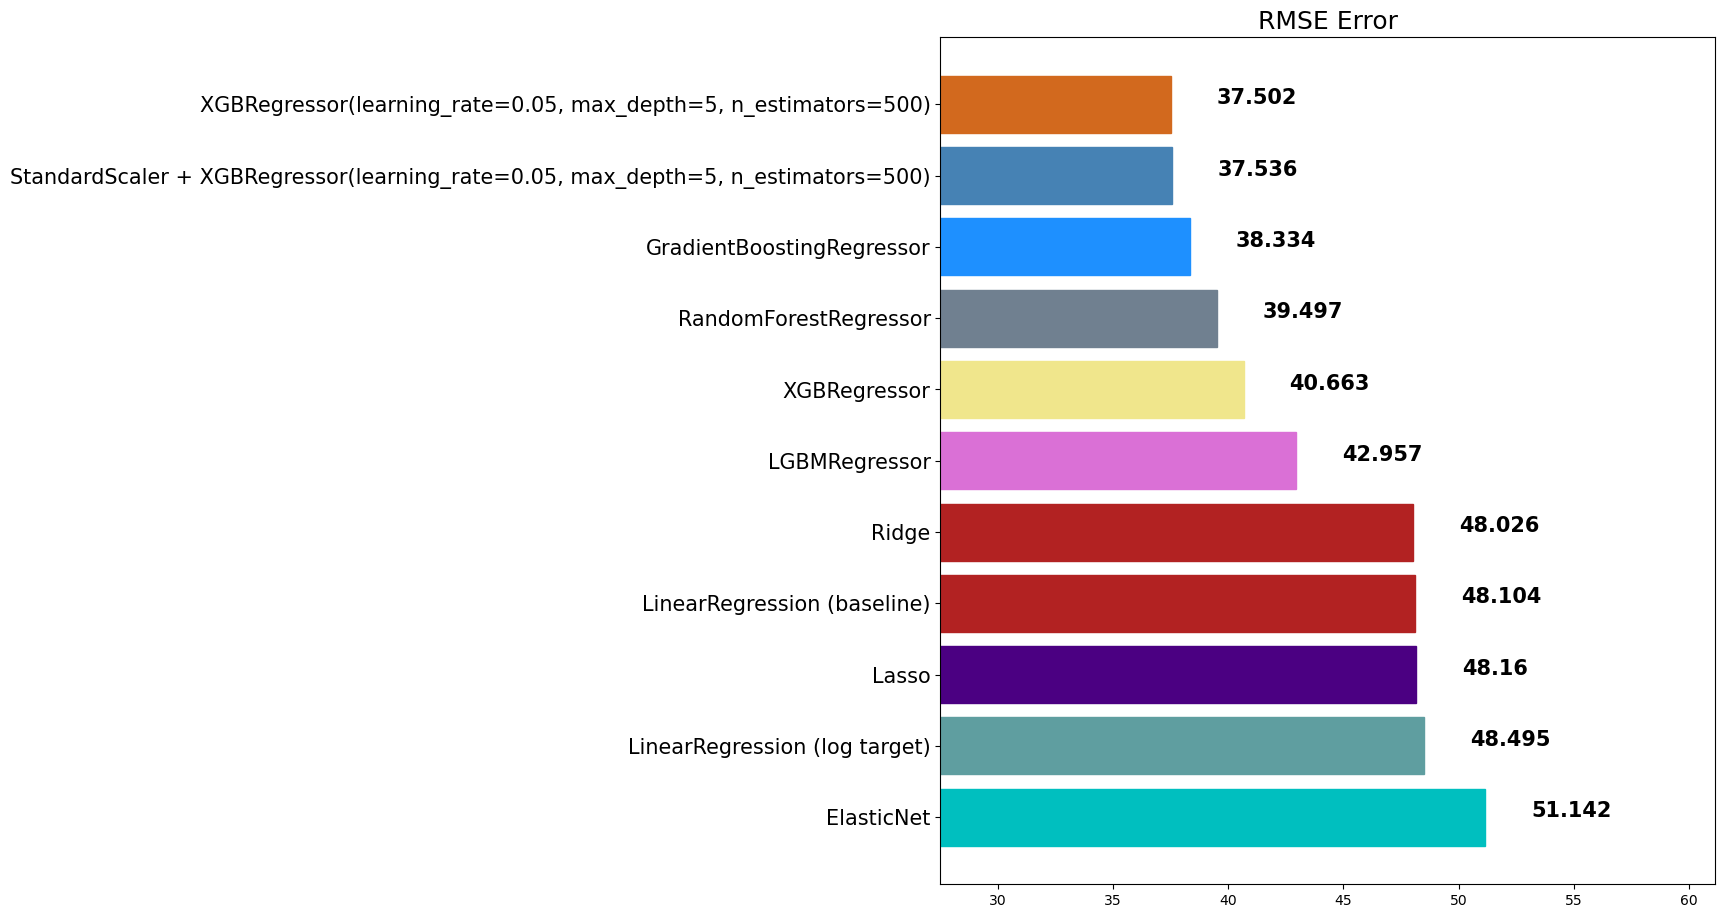

In [54]:
stdscaler = StandardScaler()

XGB_pipeline = make_pipeline(
    stdscaler,
    XGBRegressor(learning_rate=0.05, max_depth=5, n_estimators=500)
)

XGB_pred = XGB_pipeline.fit(x_train, y_train).predict(x_val)

# log 취해진 y를 원상복구
y_test = np.expm1(y_val)
pred = np.expm1(XGB_pred)

evaluate_regr(y_test, pred)
rmse_eval('StandardScaler + XGBRegressor(learning_rate=0.05, max_depth=5, n_estimators=500)', pred, y_test)
# 큰 개선 효과없음


### Ensemble - voting

In [55]:
lr_reg = LinearRegression()
ridge = Ridge(alpha=1, random_state=random_seed)
lasso = Lasso(alpha=0.01, random_state=random_seed)
lgbm_reg = LGBMRegressor(n_estimators=500, random_state=random_seed)
gbm_reg = GradientBoostingRegressor(n_estimators=500, random_state=random_seed)
rf_reg = RandomForestRegressor(n_estimators=500, random_state=random_seed)
xgb_best = XGBRegressor(learning_rate=0.05, max_depth=5, n_estimators=500)


RMSLE: 0.464, RMSE: 38.752, MAE: 26.939
                                                model       rmse
0                                          ElasticNet  51.141762
1                       LinearRegression (log target)  48.495188
2                                               Lasso  48.159539
3                         LinearRegression (baseline)  48.103872
4                                               Ridge  48.026434
5                                       LGBMRegressor  42.956500
6                                        XGBRegressor  40.662665
7                               RandomForestRegressor  39.497197
8                                  ensemble(voting 7)  38.751929
9                           GradientBoostingRegressor  38.333924
10  StandardScaler + XGBRegressor(learning_rate=0....  37.536126
11  XGBRegressor(learning_rate=0.05, max_depth=5, ...  37.502008


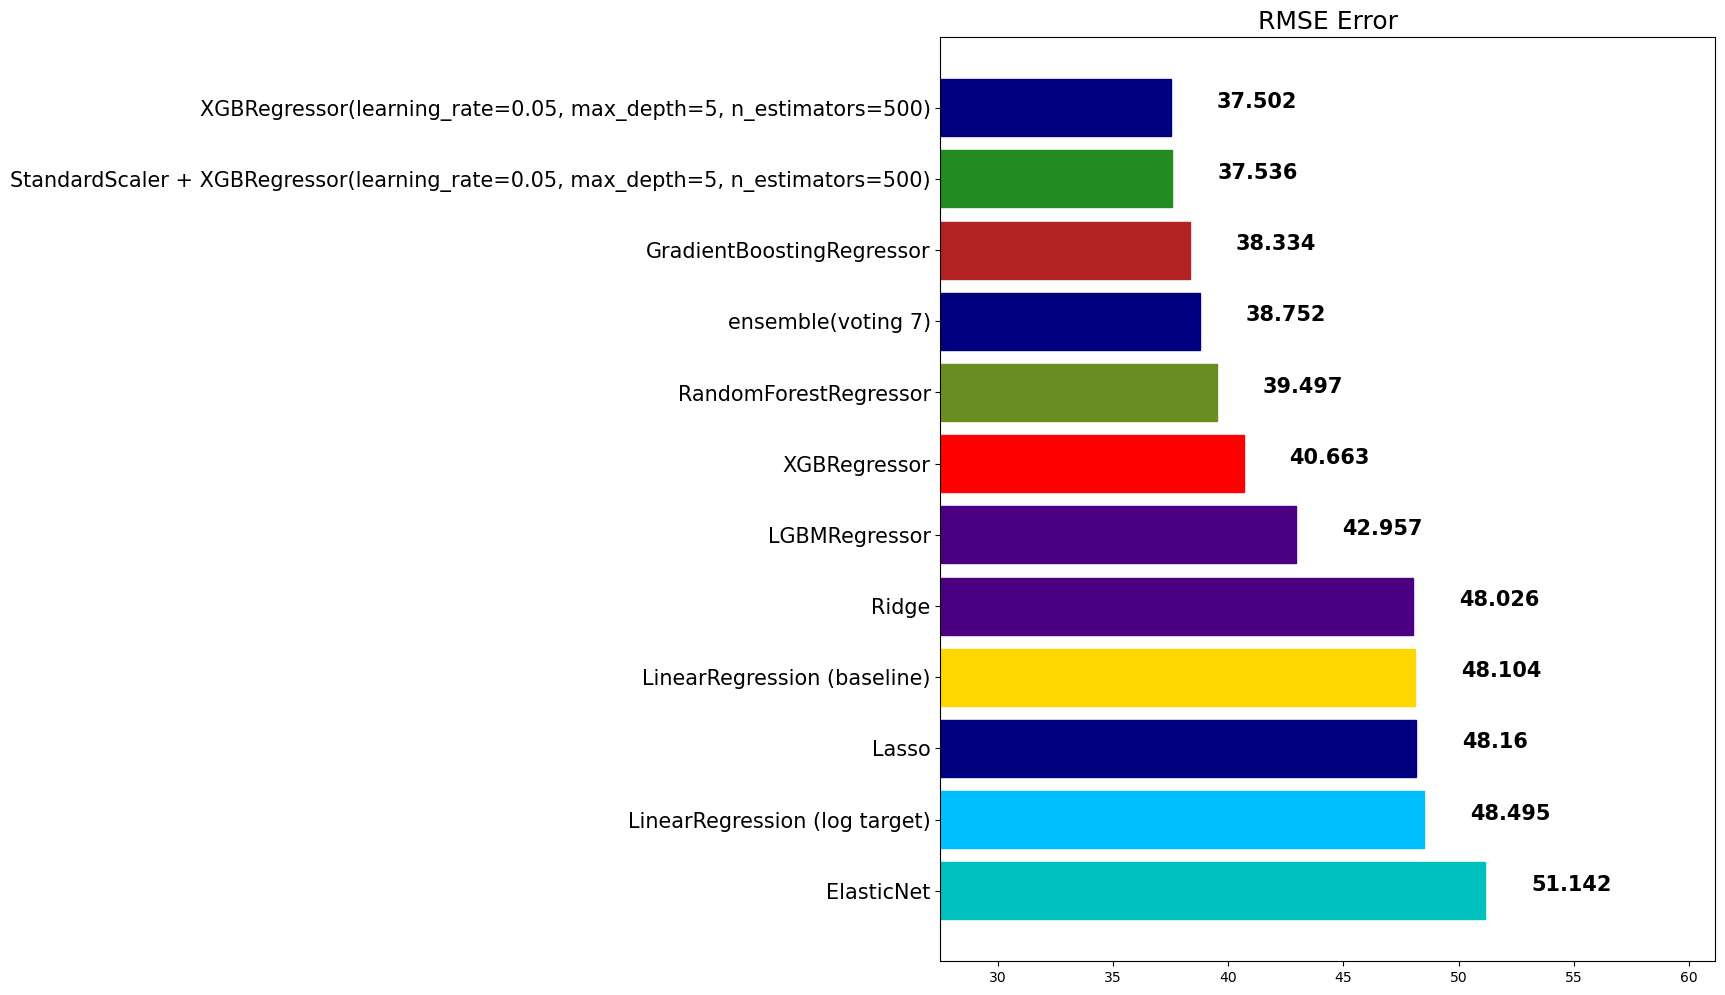

In [56]:
single_models = [
    ('lr_reg', lr_reg),
    ('ridge', ridge),
    ('lasso', lasso),
    ('lgbm_reg', lgbm_reg),
    ('gbm_reg', gbm_reg),
    ('rf_reg', rf_reg),
    ('xgb_best', xgb_best)
]

voting_regressor = VotingRegressor(single_models, n_jobs=-1)
voting_regressor.fit(x_train, y_train)
voting_pred = voting_regressor.predict(x_val)

# log 취해진 y를 원상복구
y_test = np.expm1(y_val)
pred = np.expm1(voting_pred)

evaluate_regr(y_test, pred)
rmse_eval('ensemble(voting 7)', pred, y_test)

RMSLE: 0.461, RMSE: 37.142, MAE: 25.194
                                                model       rmse
0                                          ElasticNet  51.141762
1                       LinearRegression (log target)  48.495188
2                                               Lasso  48.159539
3                         LinearRegression (baseline)  48.103872
4                                               Ridge  48.026434
5                                       LGBMRegressor  42.956500
6                                        XGBRegressor  40.662665
7                               RandomForestRegressor  39.497197
8                                  ensemble(voting 7)  38.751929
9                           GradientBoostingRegressor  38.333924
10  StandardScaler + XGBRegressor(learning_rate=0....  37.536126
11  XGBRegressor(learning_rate=0.05, max_depth=5, ...  37.502008
12                                 ensemble(voting 4)  37.142464


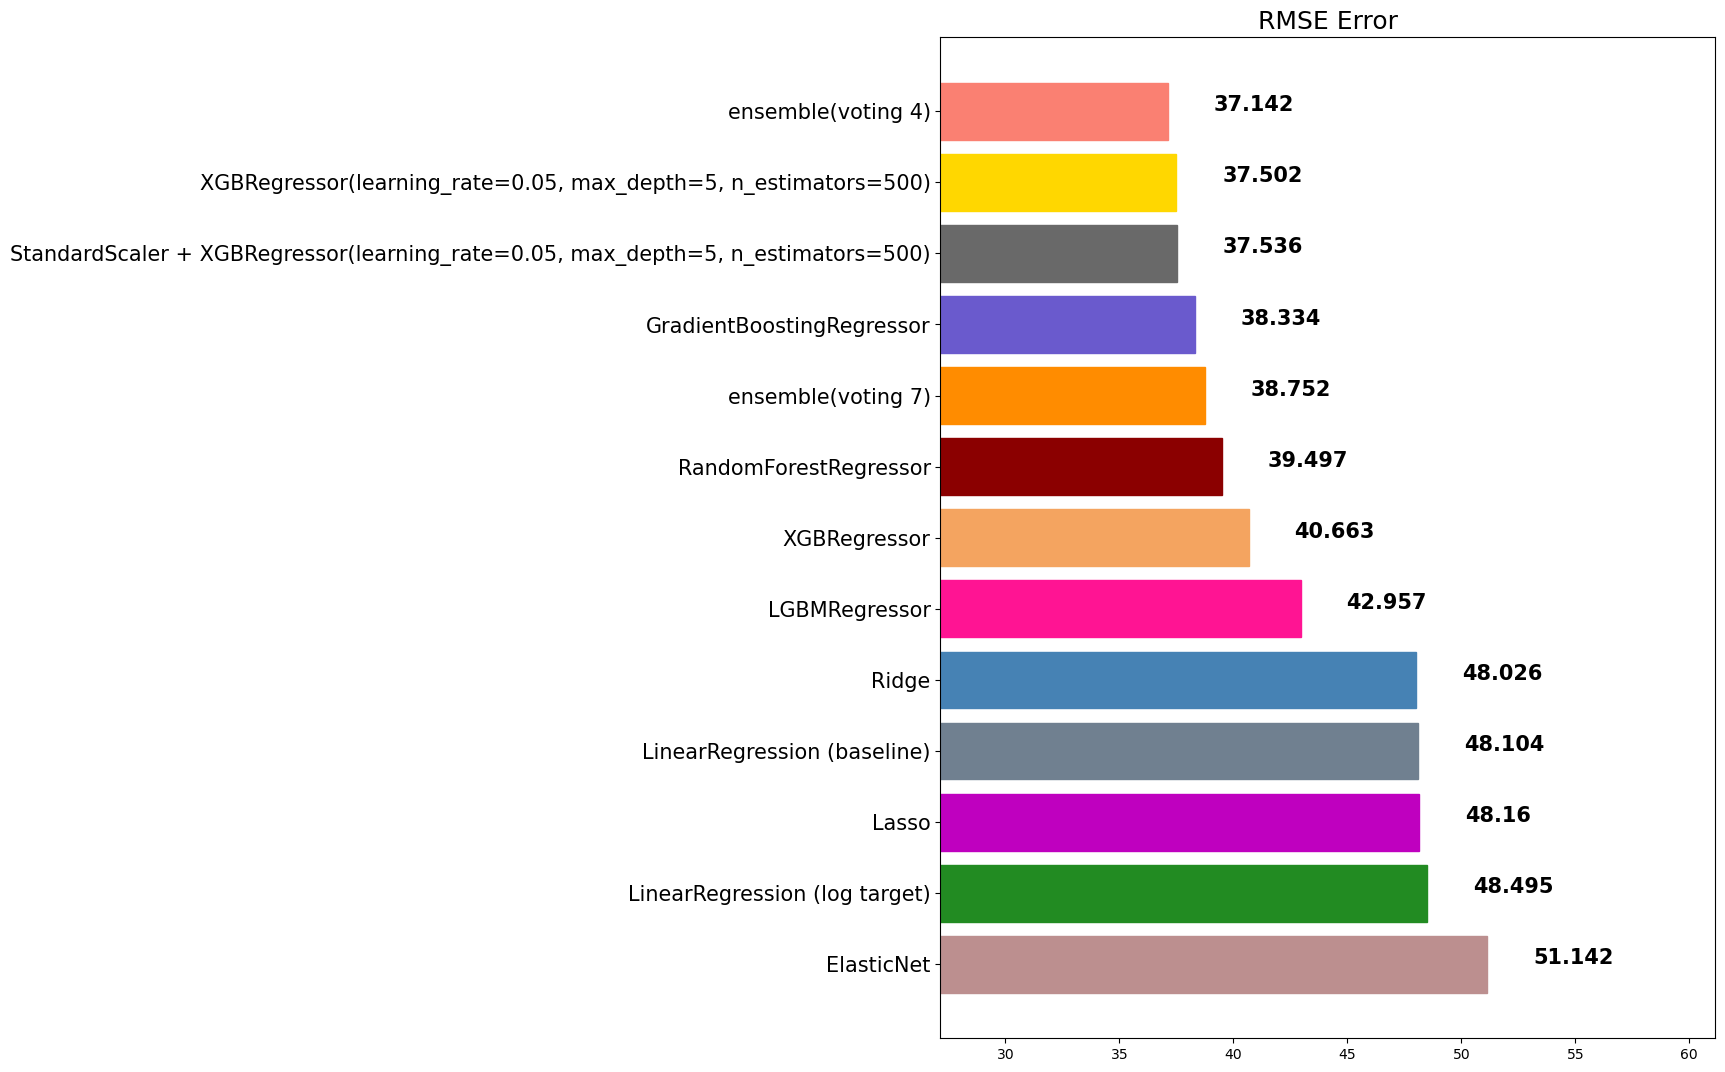

In [57]:
# 모델 4개만 ensemble
single_models = [
    ('ridge', ridge),
    ('gbm_reg', gbm_reg),
    ('rf_reg', rf_reg),
    ('xgb_best', xgb_best)
]

voting_regressor = VotingRegressor(single_models, n_jobs=-1)
voting_regressor.fit(x_train, y_train)
voting_pred = voting_regressor.predict(x_val)

# log 취해진 y를 원상복구
y_test = np.expm1(y_val)
pred = np.expm1(voting_pred)

evaluate_regr(y_test, pred)
rmse_eval('ensemble(voting 4)', pred, y_test)

### Ensemble - Stacking

In [58]:
rf_reg = RandomForestRegressor(n_estimators=500, random_state=random_seed)
gbm_reg = GradientBoostingRegressor(n_estimators=500, random_state=random_seed)
lgbm_reg = LGBMRegressor(n_estimators=500, random_state=random_seed)
xgb_reg = XGBRegressor(learning_rate=0.05, max_depth=5, n_estimators=500)

In [59]:
stack_models = [
    ('randomforest', rf_reg),
    ('gbr', gbm_reg),
    ('lgbm', lgbm_reg),
]

# 모델들의 예측값들 받아서 final_estimator=xgb
stack_reg = StackingRegressor(stack_models, final_estimator=xgb_reg, n_jobs=-1)

stack_reg.fit(x_train, y_train)
stack_pred = stack_reg.predict(x_val)


RMSLE: 0.530, RMSE: 40.821, MAE: 28.124
                                                model       rmse
0                                          ElasticNet  51.141762
1                       LinearRegression (log target)  48.495188
2                                               Lasso  48.159539
3                         LinearRegression (baseline)  48.103872
4                                               Ridge  48.026434
5                                       LGBMRegressor  42.956500
6                                  ensemble(stacking)  40.820948
7                                        XGBRegressor  40.662665
8                               RandomForestRegressor  39.497197
9                                  ensemble(voting 7)  38.751929
10                          GradientBoostingRegressor  38.333924
11  StandardScaler + XGBRegressor(learning_rate=0....  37.536126
12  XGBRegressor(learning_rate=0.05, max_depth=5, ...  37.502008
13                                 ensemble(voting

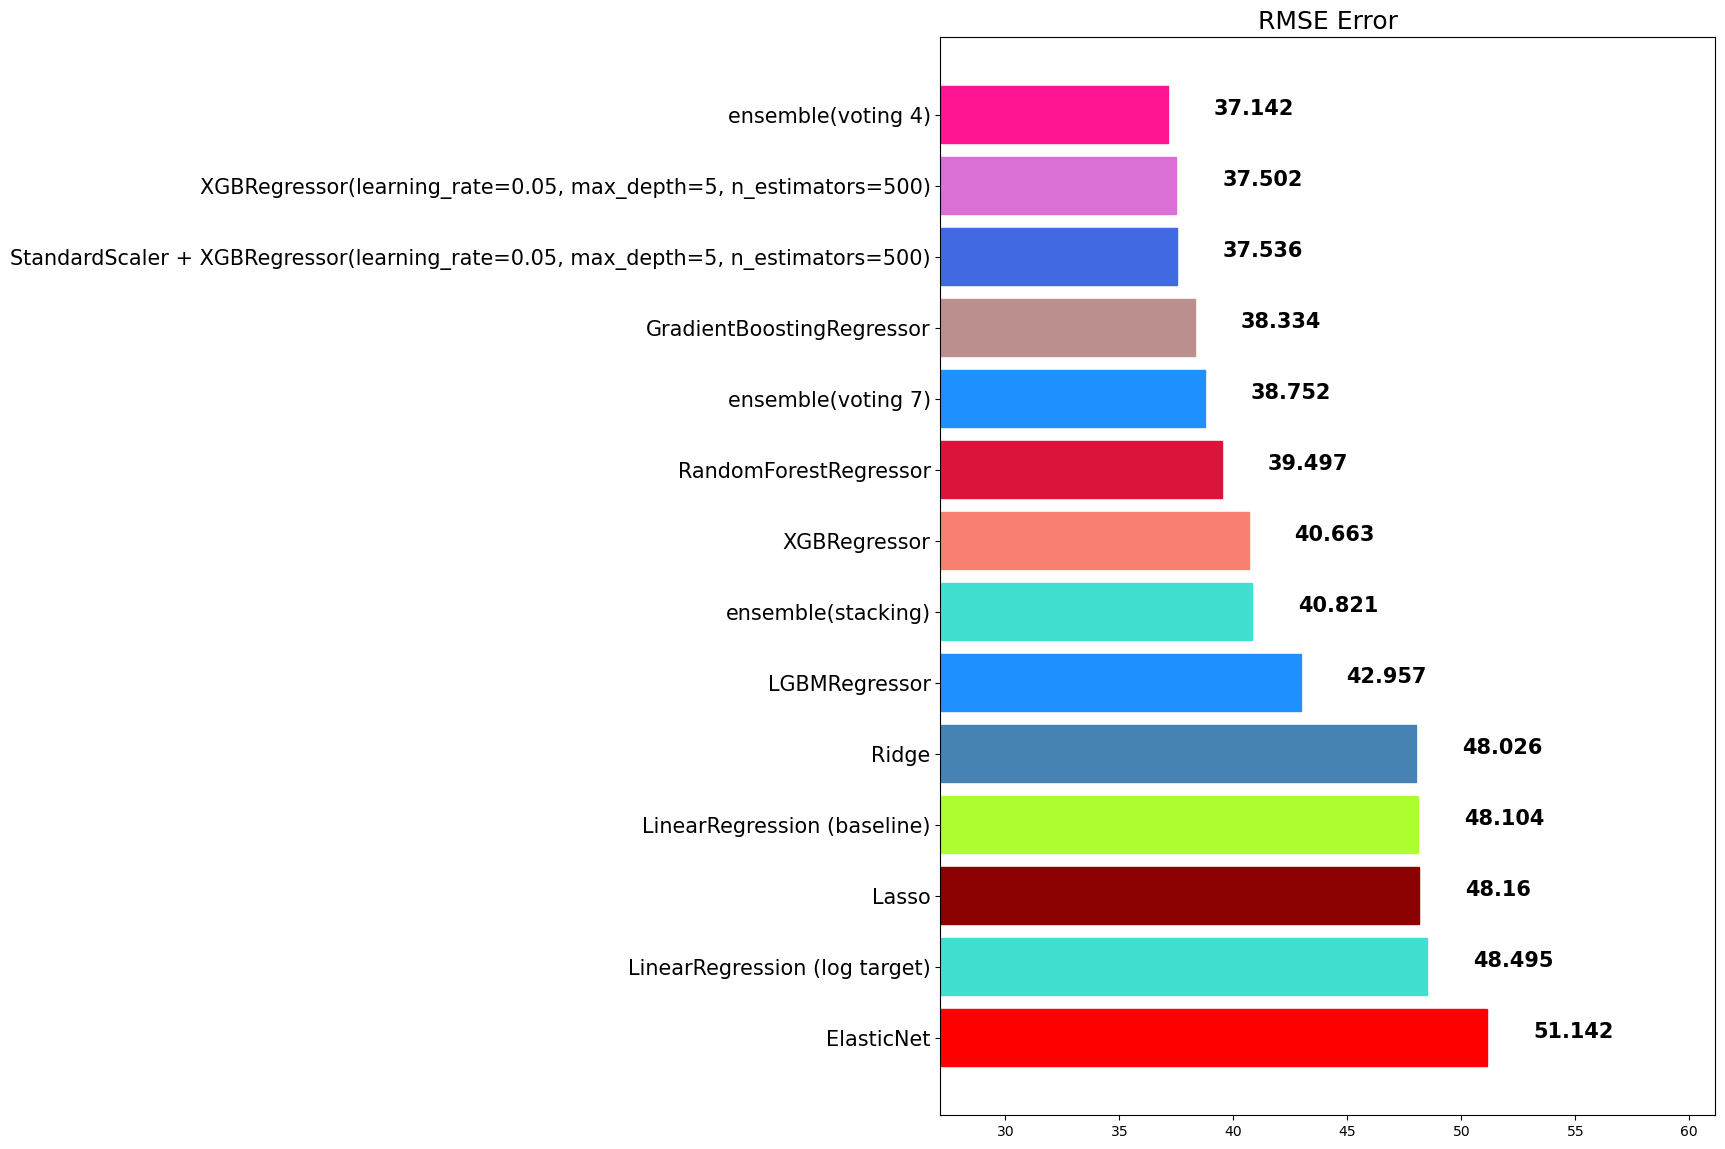

In [60]:
# log 취해진 y를 원상복구
y_test = np.expm1(y_val)
pred = np.expm1(stack_pred)

evaluate_regr(y_test, pred)
rmse_eval('ensemble(stacking)', pred, y_test)

### PyCaret

https://pycaret.gitbook.io/docs/

In [61]:
# !pip install pycaret

In [62]:
from pycaret.regression import *

In [63]:
# log 취해진 y를 원상복구
pycaret_train_df = pd.concat([x_train, np.expm1(y_train)], axis=1)
pycaret_val_df = pd.concat([x_val, np.expm1(y_val)], axis=1)

In [64]:
pycaret_train_df

,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,discomfort,count
72,2,6.4,0.0,0.9,58.0,1039.0,0.031,72.0,56.0,1143.548,3.0
1417,23,17.5,0.0,3.1,78.0,1323.0,0.043,26.0,22.0,705.455,102.0
1182,14,19.5,0.0,4.2,38.0,2000.0,0.053,18.0,14.0,299.195,224.0
609,21,15.2,0.0,1.3,68.0,747.0,0.017,60.0,50.0,769.724,144.0
1384,2,10.3,0.0,0.3,76.0,798.0,0.004,83.0,38.0,1210.265,32.0
...,...,...,...,...,...,...,...,...,...,...,...
1116,19,23.7,0.0,4.1,29.0,2000.0,0.062,28.0,17.0,132.416,282.0
954,4,15.8,0.0,2.3,84.0,387.0,0.047,68.0,36.0,892.574,23.0
1092,15,18.5,0.0,4.1,24.0,849.0,0.064,92.0,83.0,230.075,78.0
1009,12,25.0,0.0,1.8,27.0,2000.0,0.049,25.0,14.0,96.740,153.0


In [65]:
reg_model = setup(session_id=random_seed,
                  data=pycaret_train_df,
                  # test_data=y_target,
                  target='count',
                  normalize=True,
                  normalize_method='zscore',
                  transformation=False,
                  # fold_strategy='stratifiedkfold',
                  use_gpu=True)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1660 SUPER, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no

,Description,Value
0,Session id,42
1,Target,count
2,Target type,Regression
3,Original data shape,"(1165, 11)"
4,Transformed data shape,"(1165, 11)"
5,Transformed train set shape,"(815, 11)"
6,Transformed test set shape,"(350, 11)"
7,Numeric features,10
8,Preprocess,True
9,Imputation type,simple


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1660 SUPER, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no

In [66]:
# reg model 종류
models()

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1660 SUPER, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


In [67]:
pycaret_reg_models = compare_models(sort='RMSE', n_select=5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,24.9431,1350.7274,36.3302,0.7864,0.4820,0.6872,0.1010
rf,Random Forest Regressor,26.0369,1501.2111,38.3331,0.7606,0.5049,0.8120,0.1370
xgboost,Extreme Gradient Boosting,26.1112,1512.1212,38.6316,0.7583,0.5126,0.7483,0.2390
lightgbm,Light Gradient Boosting Machine,27.4005,1521.6437,38.7124,0.7563,0.5382,0.8856,0.3530
gbr,Gradient Boosting Regressor,27.4943,1618.6135,39.7332,0.7443,0.5297,0.8259,0.1270
knn,K Neighbors Regressor,33.9792,2157.5154,45.9851,0.6559,0.6625,0.9180,0.0300
ada,AdaBoost Regressor,41.5506,2643.4815,51.1202,0.5752,0.8106,1.6200,0.0680
ridge,Ridge Regression,38.9471,2689.5821,51.3522,0.5696,0.7675,1.1649,0.0110
lr,Linear Regression,38.9565,2689.6556,51.3535,0.5695,0.7643,1.1653,0.0130
br,Bayesian Ridge,38.9709,2695.5081,51.4079,0.5688,0.7678,1.1659,0.0120


In [68]:
# rmse 상위 5개 모델 ensemble
blender = blend_models(pycaret_reg_models)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,22.1675,983.4087,31.3593,0.8153,0.5296,1.0050
1,23.0049,1084.5305,32.9322,0.8129,0.3193,0.2935
2,28.4172,1813.5362,42.5856,0.7567,0.5678,0.8479
3,24.9231,1274.1130,35.6947,0.7572,0.4014,0.3779
4,26.8659,1319.5842,36.3261,0.7563,0.4304,0.4472
5,30.8620,2154.6643,46.4184,0.6892,0.8402,1.9141
6,21.6187,1073.8384,32.7695,0.8152,0.5037,1.0895
7,30.3021,1984.4503,44.5472,0.7601,0.3885,0.3441
8,20.0485,980.1835,31.3079,0.8093,0.4013,0.3730


In [69]:
blender_model = finalize_model(blender)
prediction = predict_model(blender_model, data = pycaret_val_df)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,25.5783,1592.5355,39.9066,0.7540,0.5025,0.6051


In [70]:
# 모델 골라서 emsemble
rf_model = create_model('rf')
lightgbm_model = create_model('lightgbm')
knn_model = create_model('knn')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,22.4371,1042.6384,32.2899,0.8042,0.5330,1.0668
1,24.8589,1261.2251,35.5137,0.7825,0.3127,0.2911
2,27.8888,1936.6439,44.0073,0.7402,0.5805,0.9134
3,26.2254,1436.8640,37.9060,0.7262,0.4159,0.3848
4,28.9740,1567.3877,39.5902,0.7105,0.4500,0.4739
5,32.1995,2405.7759,49.0487,0.6529,0.8646,2.0026
6,21.5223,1015.4867,31.8667,0.8252,0.5113,1.1035
7,30.8221,2030.1555,45.0572,0.7546,0.3871,0.3543
8,21.8737,1125.9437,33.5551,0.7809,0.4147,0.3887


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,25.1444,1158.9084,34.0427,0.7824,0.6150,1.4079
1,25.1566,1235.8917,35.1553,0.7868,0.3485,0.3270
2,30.7129,1856.9125,43.0919,0.7509,0.6205,0.8917
3,27.3557,1461.9588,38.2356,0.7214,0.4220,0.4066
4,28.9489,1514.6664,38.9187,0.7202,0.4696,0.4868
5,32.8474,2287.9285,47.8323,0.6699,0.8790,2.0142
6,26.4193,1343.6654,36.6560,0.7687,0.5552,1.1932
7,31.0571,2050.2488,45.2797,0.7522,0.4335,0.3618
8,22.7234,1140.4924,33.7712,0.7781,0.4330,0.4110


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,29.8415,1550.9351,39.3819,0.7088,0.7172,1.2390
1,32.1122,1880.7422,43.3675,0.6756,0.5728,0.5487
2,36.5463,2521.1904,50.2115,0.6617,0.6525,0.7294
3,30.5976,1548.8053,39.3549,0.7049,0.6010,0.6661
4,36.9171,2449.8521,49.4960,0.5475,0.5665,0.5520
5,41.8222,3223.2544,56.7737,0.5350,0.9392,1.8295
6,30.3235,1526.8787,39.0753,0.7372,0.6598,1.0392
7,39.6741,3224.7271,56.7867,0.6102,0.5881,0.5135
8,29.7827,1907.1744,43.6712,0.6289,0.5907,0.6729


In [71]:
# 모델 3개 ensemble
blender_3 = blend_models(estimator_list=[rf_model, lightgbm_model, knn_model])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,22.4300,930.1330,30.4981,0.8253,0.5718,1.1741
1,25.4995,1186.9452,34.4521,0.7953,0.3657,0.3573
2,28.9151,1740.8863,41.7239,0.7664,0.5789,0.7899
3,23.4995,1162.6736,34.0980,0.7785,0.4388,0.4226
4,29.2458,1519.0524,38.9750,0.7194,0.4502,0.4683
5,33.3638,2315.2838,48.1174,0.6660,0.8623,1.9065
6,23.4042,1043.7054,32.3064,0.8204,0.5353,1.0626
7,32.4072,2134.6123,46.2019,0.7420,0.4173,0.3877
8,22.0007,1025.6416,32.0256,0.8004,0.4371,0.4373


In [72]:
final_model = finalize_model(blender_3)
prediction = predict_model(final_model, data = pycaret_val_df)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,27.3102,1488.1182,38.5761,0.7701,0.5341,0.7051


### Hyperopt (xgboost)

In [73]:
# !pip install hyperopt

In [74]:
from hyperopt import hp, STATUS_OK
from hyperopt.pyll.base import scope

In [75]:
reg_candidate = [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 5, 10, 100]

xgb_search_space = {'max_depth': scope.int(hp.quniform("max_depth", 1, 15, 1)),
                    # 'gamma': hp.uniform ('gamma', 0, 1),
                    'reg_alpha' : hp.choice('reg_alpha', reg_candidate),
                    'reg_lambda' : hp.choice('reg_lambda', reg_candidate),
                    'colsample_bytree' : hp.quniform('colsample_bytree', 0.6, 1, 0.05),
                    # 'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
                    'n_estimators': scope.int(hp.quniform("n_estimators", 100, 1500, 100)),
                    'learning_rate': hp.quniform ('learning_rate', 0.01, 0.1, 0.005),
                    'random_state': random_seed,
                    'max_bin' : scope.int(hp.quniform('max_bin', 200, 550, 1))}

In [76]:
#Define the hyperopt objective.
def hyperparameter_tuning(space):
    model = XGBRegressor(**space)

    #Define evaluation datasets.
    evaluation = [(x_train, y_train), (x_val, y_val)]

    #Fit the model. Define evaluation sets, early_stopping_rounds, and eval_metric.
    model.fit(x_train, y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=100,verbose=False)

    #Obtain prediction and rmse score.
    pred = model.predict(x_val)

    # log 취해진 y를 expm1로 원상복구
    rmse = mean_squared_error(np.expm1(y_val), np.expm1(pred), squared=False)
    print ("SCORE:", rmse)

    #Specify what the loss is for each model.
    return {'loss':rmse, 'status': STATUS_OK, 'model': model}

In [77]:
from hyperopt import fmin, tpe, Trials

trials = Trials()

# fmin()함수를 호출. max_evals지정된 횟수만큼 반복 후 목적함수의 최소값을 가지는 최적 입력값 추출.
best = fmin(fn=hyperparameter_tuning,
            space=xgb_search_space,
            algo=tpe.suggest,
            max_evals=100, # 최대 반복 횟수를 지정합니다.
            trials=trials, rstate=np.random.default_rng(seed=random_seed))

print('best:', best)

SCORE:                                                 
41.5046849480068                                       
SCORE:                                                                         
40.024936491365324                                                             
SCORE:                                                                           
39.22010992877537                                                                
SCORE:                                                                           
39.00902470752805                                                               
SCORE:                                                                          
39.73533600802313                                                               
SCORE:                                                                          
40.882125574345125                                                              
SCORE:                                                                       

In [78]:
#Create instace of best model.
best_model = trials.results[np.argmin([r['loss'] for r in
    trials.results])]['model']

#Examine model hyperparameters
print(best_model)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.75, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.035, max_bin=406,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=600, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)


RMSLE: 0.471, RMSE: 36.948, MAE: 24.951
                                                model       rmse
0                                          ElasticNet  51.141762
1                       LinearRegression (log target)  48.495188
2                                               Lasso  48.159539
3                         LinearRegression (baseline)  48.103872
4                                               Ridge  48.026434
5                                       LGBMRegressor  42.956500
6                                  ensemble(stacking)  40.820948
7                                        XGBRegressor  40.662665
8                               RandomForestRegressor  39.497197
9                                  ensemble(voting 7)  38.751929
10                          GradientBoostingRegressor  38.333924
11  StandardScaler + XGBRegressor(learning_rate=0....  37.536126
12  XGBRegressor(learning_rate=0.05, max_depth=5, ...  37.502008
13                                 ensemble(voting

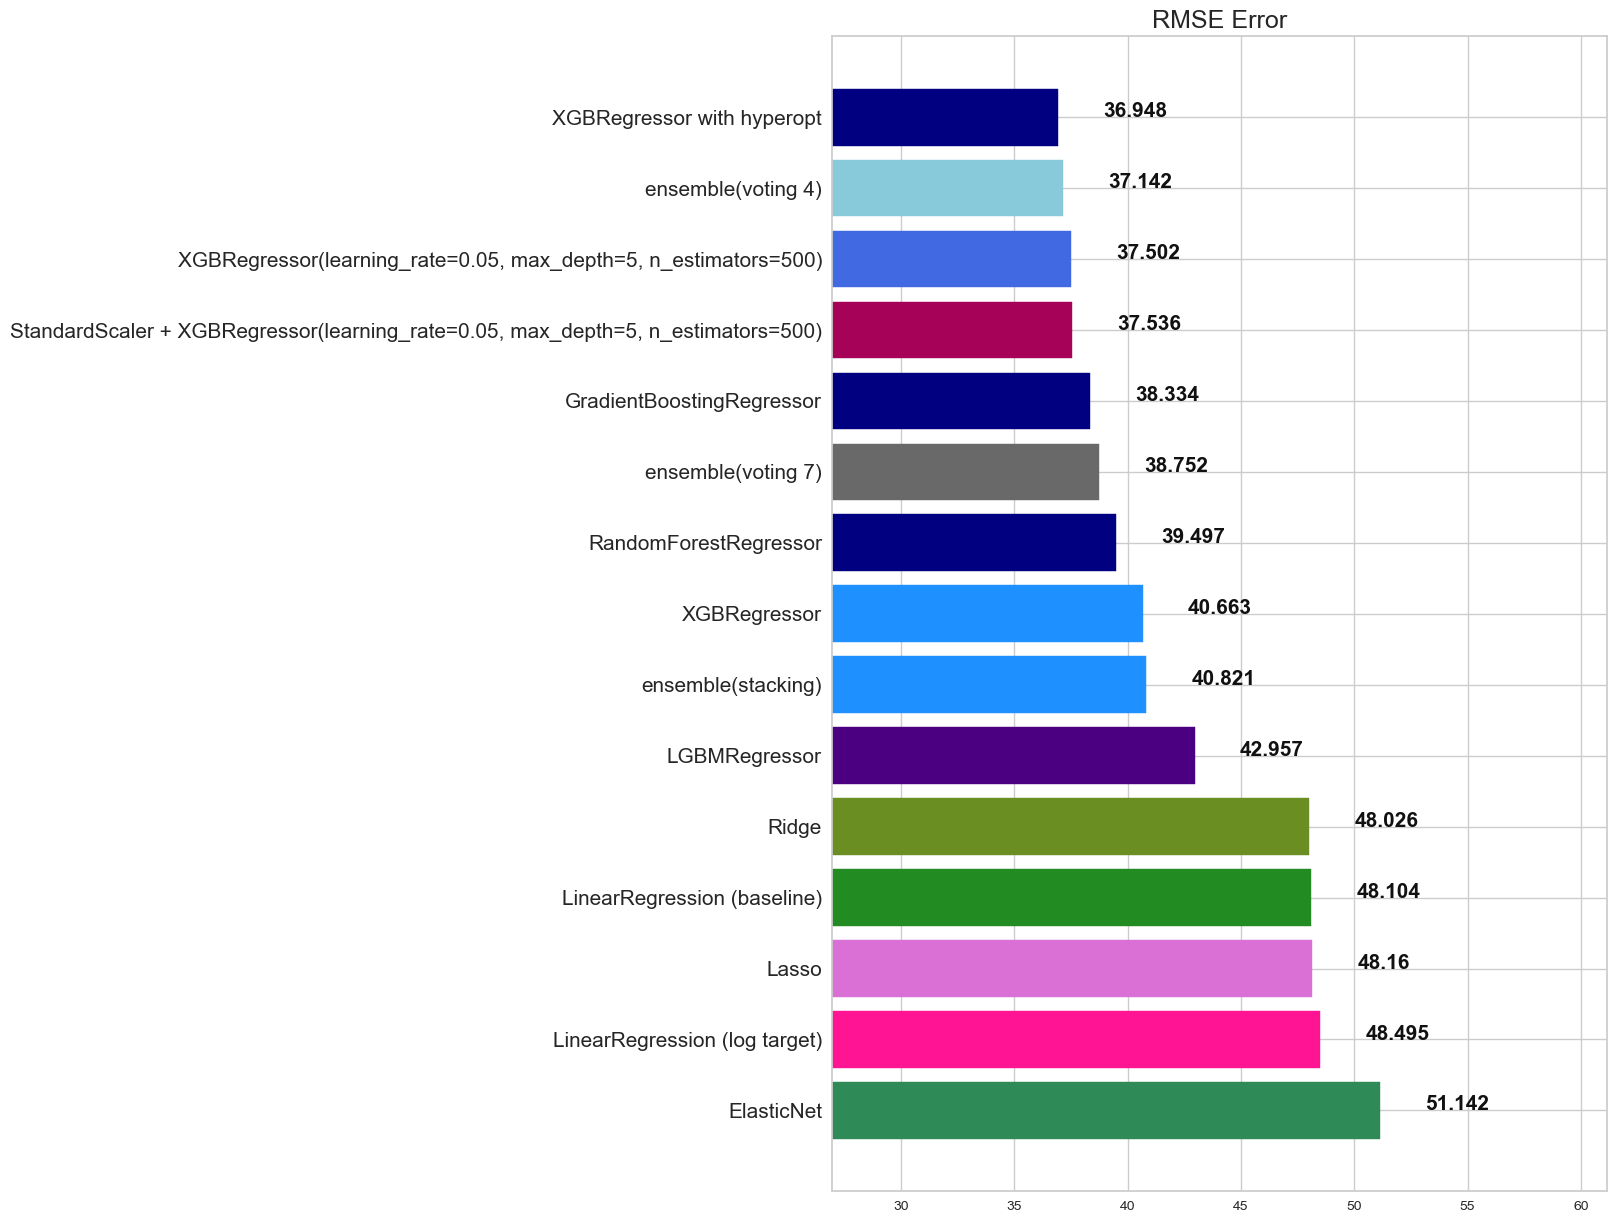

In [79]:
xgb_best_pred = best_model.predict(x_val)

y_test = np.expm1(y_val)
pred = np.expm1(xgb_best_pred)

evaluate_regr(y_test, pred)
rmse_eval('XGBRegressor with hyperopt', pred, y_test)

## dacon에 제출 시 submission 파일 만드는 방법

In [80]:
submission = pd.read_csv(r'..\서울시따릉이대여량예측\submission.csv')
submission

,id,count
0,0,NaN
1,1,NaN
2,2,NaN
3,4,NaN
4,5,NaN
...,...,...
710,2148,NaN
711,2149,NaN
712,2165,NaN
713,2166,NaN


In [81]:
test_df.isnull().sum()

id                         0
hour                       0
hour_bef_temperature       1
hour_bef_precipitation     1
hour_bef_windspeed         1
hour_bef_humidity          1
hour_bef_visibility        1
hour_bef_ozone            35
hour_bef_pm10             37
hour_bef_pm2.5            36
dtype: int64

In [82]:
# Null값은 median으로 채운다

include_null_col = ["hour_bef_temperature", "hour_bef_precipitation", "hour_bef_windspeed", "hour_bef_humidity",
                     "hour_bef_visibility", "hour_bef_ozone", "hour_bef_pm10", "hour_bef_pm2.5"]

for col_name in include_null_col:
    imputer = SimpleImputer(strategy='median')
    result = imputer.fit_transform(test_df[col_name].values.reshape(-1,1))
    test_df[col_name] = result

In [83]:
test_df.isnull().sum()

id                        0
hour                      0
hour_bef_temperature      0
hour_bef_precipitation    0
hour_bef_windspeed        0
hour_bef_humidity         0
hour_bef_visibility       0
hour_bef_ozone            0
hour_bef_pm10             0
hour_bef_pm2.5            0
dtype: int64

In [84]:
# 불쾌지수 열 추가
test_df['discomfort'] = (1.8 * test_df['hour_bef_temperature']) - (-0.55 * (1 - test_df['hour_bef_humidity'])) * (1.8 * (test_df['hour_bef_temperature'] - 26)) +26

In [85]:
# 원하는 모델 들고와서 test 예측
model = voting_regressor

test_pred = model.predict(test_df.drop('id', axis=1))
test_pred = np.expm1(test_pred)

In [86]:
submission['count'] = test_pred

In [87]:
submission

,id,count
0,0,85.436210
1,1,208.035724
2,2,27.424292
3,4,40.049022
4,5,34.048179
...,...,...
710,2148,61.162951
711,2149,50.916664
712,2165,109.128701
713,2166,149.799476


In [88]:
############ 저장할 모델명 수정 ###############
model_name = "저장할모델명"
submission.to_csv('../prediction/{}.csv'.format(model_name) ,index = False)